<a href="https://colab.research.google.com/github/chatwipa-sur/SRCC_detection/blob/main/Teacher_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trian teacher model
- Train CenterNet model with original ground truth label

In [1]:
# Standard library for file and directory operations
import os

# Library for parsing XML files (used for annotations)
import xml.etree.ElementTree as ET

# Core PyTorch library for tensor operations
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import random_split
import torch.nn as nn
import torchvision

# Library for numerical computations
import numpy as np
import pandas as pd

# Library for data visualization
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm

In [2]:
# Mount the drive with google colab notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Create Dataset

In [3]:
# Make heatmaps using the utility functions from the centernet repo
# Draw a Gaussian centered at a point on a heatmap
def draw_msra_gaussian(heatmap, center, sigma=2):
  # Total size (radius) of the Gaussian region
  tmp_size = sigma * 6

  # Round the x and y center to nearest int
  mu_x = int(center[0] + 0.5)
  mu_y = int(center[1] + 0.5)

  # Get heatmap dimensions
  w, h = heatmap.shape[0], heatmap.shape[1]

  # Upper-left and bottom-right corners of the Gaussian patch
  ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
  br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]

  # If Gaussian patch is completely outside the heatmap, return
  if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
    return heatmap

  # Create a 2D Gaussian
  size = 2 * tmp_size + 1 # Size of the Gaussian patch
  x = np.arange(0, size, 1, np.float32) # x coordinates
  y = x[:, np.newaxis] # y coordinates
  x0 = y0 = size // 2 # Center of the Gaussian
  g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2)) # 2D Gaussian formula

  # Compute valid bounds for placing the Gaussian patch on the heatmap
  g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
  g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
  img_x = max(0, ul[0]), min(br[0], h)
  img_y = max(0, ul[1]), min(br[1], w)

  # Place the Gaussian on the heatmap using max to retain highest intensity
  heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
    g[g_y[0]:g_y[1], g_x[0]:g_x[1]])

  return heatmap

# Draw a dense regression value map around a center point
def draw_dense_reg(regmap, heatmap, center, value, radius, is_offset=False):
  # Size of the square region
  diameter = 2 * radius + 1
  # Create Gaussian mask
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

  # Convert value to float32 and reshape to [dim, 1, 1]
  value = np.array(value, dtype=np.float32).reshape(-1, 1, 1)
  dim = value.shape[0]

  # Create a repeated value map of shape [dim, H, W]
  reg = np.ones((dim, diameter*2+1, diameter*2+1), dtype=np.float32) * value

  # If it's an offset, adjust the values using distance from center
  if is_offset and dim == 2:
    delta = np.arange(diameter*2+1) - radius
    reg[0] = reg[0] - delta.reshape(1, -1)
    reg[1] = reg[1] - delta.reshape(-1, 1)

  # Center coordinates
  x, y = int(center[0]), int(center[1])

  # Heatmap dimensions
  height, width = heatmap.shape[0:2]

  # Compute boundaries (clipping at image edges)
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  # Crop regions from heatmap, regmap, Gaussian, and value maps
  masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
  masked_regmap = regmap[:, y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom,
                             radius - left:radius + right]
  masked_reg = reg[:, radius - top:radius + bottom,
                      radius - left:radius + right]

  # Only update if region is valid (non-zero size)
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug

    # Create a mask where Gaussian is stronger than existing heatmap
    idx = (masked_gaussian >= masked_heatmap).reshape(1, masked_gaussian.shape[0],
                                                      masked_gaussian.shape[1])

    # Update regmap only where mask is True (using Gaussian gate)
    masked_regmap = (1-idx) * masked_regmap + idx * masked_reg

  # Write updated region back to original regmap
  regmap[:, y - top:y + bottom, x - left:x + right] = masked_regmap

  return regmap

def gaussian2D(shape, sigma=1):
    # Get center and coordinate grid
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    # Apply 2D Gaussian function
    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))

    # Remove near-zero values for stability
    h[h < np.finfo(h.dtype).eps * h.max()] = 0

    return h

def make_hm_regr(target, input_size=512, MODEL_SCALE=4):

    IN_SCALE = 1
    # make output heatmap for single class
    hm = np.zeros([input_size//MODEL_SCALE, input_size//MODEL_SCALE], dtype=np.float32)
    # make regr heatmap
    regr = np.zeros([2, input_size//MODEL_SCALE, input_size//MODEL_SCALE], dtype=np.float32)

    if target.empty:
        return hm, regr

    center = np.array([target["x"] + target["w"]//2, target["y"] + target["h"]//2,
                       target["w"], target["h"]]).T

    # make a center point
    # try gaussian points.
    for c in center:
        hm = draw_msra_gaussian(hm, [int(c[0])//MODEL_SCALE//IN_SCALE,
                                     int(c[1])//MODEL_SCALE//IN_SCALE],
                                sigma=np.clip(c[2]*c[3]//2000, 2, 4))

    # convert targets to its center.
    regrs = center[:, 2:]/input_size/IN_SCALE

    # plot regr values to mask
    for r, c in zip(regrs, center):
        for i in range(-2, 3):
            for j in range(-2, 3):
                try:
                    regr[:, int(c[0])//MODEL_SCALE//IN_SCALE+i,
                         int(c[1])//MODEL_SCALE//IN_SCALE+j] = r
                except:
                    pass
    regr[0] = regr[0].T; regr[1] = regr[1].T;

    return hm, regr

def pred2box(hm, regr, thresh=0.99, MODEL_SCALE=4, input_size=512):
    pred = hm > thresh
    pred_center = np.where(pred)
    pred_r = regr[:, pred].T  # Shape: [N, 2] for w, h
    boxes = []
    scores = hm[pred]

    for i, b in enumerate(pred_r):
        cx = pred_center[1][i] * MODEL_SCALE
        cy = pred_center[0][i] * MODEL_SCALE

        w = b[0] * input_size
        h = b[1] * input_size

        x1 = cx - w /2
        y1 = cy - h /2

        arr = np.clip([x1, y1, w, h], 0, input_size)
        boxes.append(arr)

    return np.asarray(boxes), scores


# Assuming `image` is a torch.Tensor of shape (3, H, W)
def unnormalize_tensor(image):
  mean = [0.485, 0.456, 0.406]
  std  = [0.229, 0.224, 0.225]
  for t, m, s in zip(image, mean, std):
    t.mul_(s).add_(m)
  return image

In [4]:
class SignetRingCellPatchCenterNetDataset(Dataset):
  def __init__(self, image_dir, annotation_dir, patch_size=512, transform=None):
    # Initialize parameters
    self.patch_size = patch_size
    self.stride = patch_size//2  # 50% overlap for 512x512 patches
    self.transform = transform
    self.image_information = []

    # Loop over positive and negative folders
    for class_type in ['positive']:
      full_image_dir = os.path.join(image_dir, class_type)
      full_anno_dir = os.path.join(annotation_dir, class_type)

      # Iterate over image files in the folder
      for fname in os.listdir(full_image_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
          # Collect image path
          image_path = os.path.join(full_image_dir, fname)

          # Collect annotation path
          if class_type == "positive":
            anno_filename = fname.replace('.png', '.xml').replace('.jpg', '.xml').replace('.jpeg', '.xml')
            anno_path = os.path.join(full_anno_dir, anno_filename)
          else:
            anno_path = None  # no annotation for negatives

          # Get the size of image
          image = cv2.imread(image_path)
          height, width = image.shape[:2]

          # Generate sliding window patches
          for top in range(0, height - self.patch_size + 1, self.stride):
            for left in range(0, width - self.patch_size + 1, self.stride):
              self.image_information.append({
                  'image_path': image_path,
                  'annotation_path': anno_path,
                  'crop_box': (left, top, left + self.patch_size, top + self.patch_size)
              })

  def __len__(self):
    return len(self.image_information) # Total number of patches

  def __getitem__(self, idx):
    # Get image for this index
    image_info = self.image_information[idx]
    image = cv2.imread(image_info['image_path'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Crop patch using numpy slicing: [top:bottom, left:right]
    left, top, right, bottom = image_info['crop_box']
    image_patch = image[top:bottom, left:right]

    # Load and process annotations
    boxes_list = []
    if image_info['annotation_path'] is not None:
        tree = ET.parse(image_info['annotation_path'])
        root = tree.getroot()

        crop_xmin, crop_ymin, crop_xmax, crop_ymax = image_info['crop_box']
        for obj in root.findall('object'):
            name = obj.find('name').text
            if name == 'ring_cell_cancer':
                bbox = obj.find('bndbox')
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)

                if (xmin >= crop_xmin and xmax <= crop_xmax) and (ymin >= crop_ymin and ymax <= crop_ymax):
                    new_xmin = xmin - crop_xmin
                    new_ymin = ymin - crop_ymin
                    new_xmax = xmax - crop_xmin
                    new_ymax = ymax - crop_ymin
                    boxes_list.append((new_xmin, new_ymin,
                                       new_xmax - new_xmin,
                                       new_ymax - new_ymin))

    # Generate heatmap and regression map as before
    if len(boxes_list) == 0:
        hm = np.zeros([self.patch_size // 4, self.patch_size // 4], dtype=np.float32)
        regr = np.zeros([2, self.patch_size // 4, self.patch_size // 4], dtype=np.float32)
    else:
        target = pd.DataFrame(boxes_list, columns=['x', 'y', 'w', 'h'])
        hm, regr  = make_hm_regr(target)

    # Apply transforms if any
    if self.transform:
        image_patch = self.transform(image_patch)

    return image_patch, hm, regr, boxes_list

#### Check `SignetRingCellPatchDataset` function

In [7]:
# Transform function
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert NumPy to PIL
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Path of dataset
image_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/dataset/train"
annotation_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/dataset/annotations/train"

# Load dataset and patching
dataset = SignetRingCellPatchCenterNetDataset(image_dir, annotation_dir, transform=transform)

torch.Size([3, 512, 512])


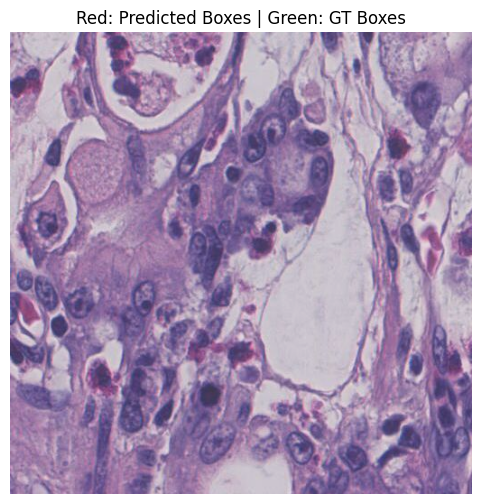

In [8]:
# Get image
image, hm, regr, gt_boxes = dataset[0]
print(image.shape)
image = unnormalize_tensor(image.clone())

# Get predicted boxes
pred_boxes, _ = pred2box(hm, regr)

# Convert image to numpy
image = image.clone().permute(1, 2, 0).numpy()
image = (image * 255).astype(np.uint8)

# Make a copy for drawing
image_copy = image.copy()

# Draw predicted boxes (red)
for box in pred_boxes:
    x, y, w, h = map(int, box)
    cv2.rectangle(image_copy, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Draw GT boxes (green)
for box in gt_boxes:
    x1, y1, w, h = map(int, box)
    cv2.rectangle(image_copy, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 2)

# Display
plt.figure(figsize=(6, 6))
plt.imshow(image_copy)
plt.title("Red: Predicted Boxes | Green: GT Boxes")
plt.axis("off")
plt.show()

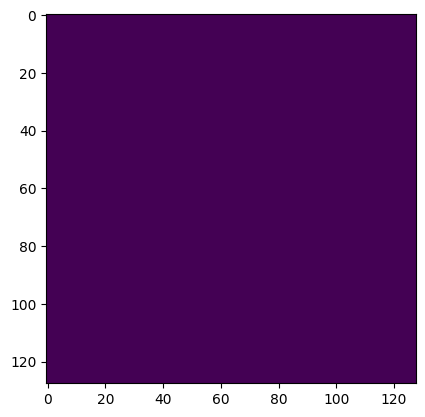

In [9]:
plt.imshow(hm)

torch.Size([3, 512, 512])


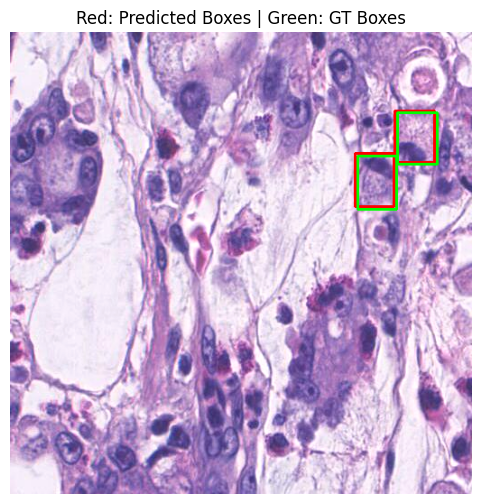

In [10]:
# Get image
image, hm, regr, gt_boxes = dataset[1]
print(image.shape)
image = unnormalize_tensor(image.clone())

# Get predicted boxes
pred_boxes, _ = pred2box(hm, regr)

# Convert image to numpy
image = image.clone().permute(1, 2, 0).numpy()
image = (image * 255).astype(np.uint8)

# Make a copy for drawing
image_copy = image.copy()

# Draw predicted boxes (red)
for box in pred_boxes:
    x, y, w, h = map(int, box)
    cv2.rectangle(image_copy, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Draw GT boxes (green)
for box in gt_boxes:
    x1, y1, w, h = map(int, box)
    cv2.rectangle(image_copy, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 2)

# Display
plt.figure(figsize=(6, 6))
plt.imshow(image_copy)
plt.title("Red: Predicted Boxes | Green: GT Boxes")
plt.axis("off")
plt.show()

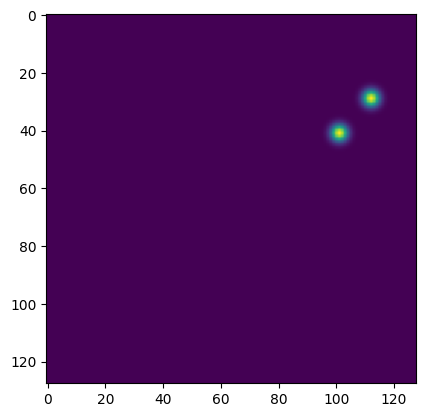

In [11]:
plt.imshow(hm)

## 2. Create DataLoader

In [12]:
transform = transforms.Compose([
    transforms.ToTensor()
])

# Paths
dataset_base_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/dataset"

# Train and Validation dataset
full_train_dataset = SignetRingCellPatchCenterNetDataset(
    image_dir=os.path.join(dataset_base_dir, "train"),
    annotation_dir=os.path.join(dataset_base_dir, "annotations/train"),
    transform=transform
)

# 90% training, 10% validation
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Test dataset
test_dataset = SignetRingCellPatchCenterNetDataset(
    image_dir=os.path.join(dataset_base_dir, "test"),
    annotation_dir=os.path.join(dataset_base_dir, "annotations/test"),
    transform=transform
)

# Define a custom collate function to handle the variable-length gt_boxes
def custom_collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    hms = torch.stack([torch.from_numpy(item[1]).float() for item in batch])
    regrs = torch.stack([torch.from_numpy(item[2]).float() for item in batch])
    gt_boxes = [item[3] for item in batch]

    return images, hms, regrs, gt_boxes

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

Check `train_loader` function

In [13]:
for batch in train_loader:
    if batch is None:
        continue
    images, hm, regr, gt_boxes = batch
    print(f"Loaded batch with {len(images)} images")
    break

Loaded batch with 32 images


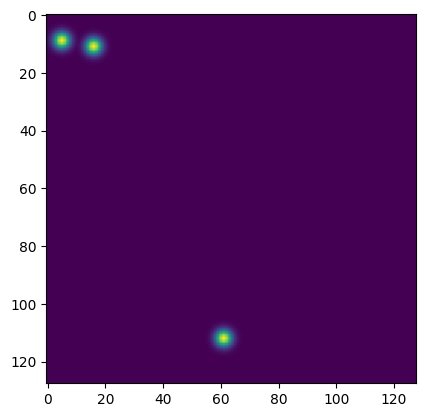

In [14]:
plt.imshow(hm[0])

Check `val_loader` function

In [15]:
for batch in val_loader:
    if batch is None:
        continue
    images, hm, regr, gt_boxes = batch
    print(f"Loaded batch with {len(images)} images")
    break

Loaded batch with 32 images


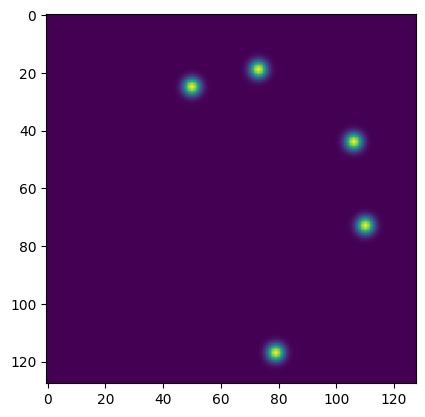

In [16]:
plt.imshow(hm[0])

Check `test_loader` function

In [17]:
for batch in test_loader:
    if batch is None:
        continue
    images, hm, regr, gt_boxes = batch
    print(f"Loaded batch with {len(images)} images")
    break

Loaded batch with 32 images


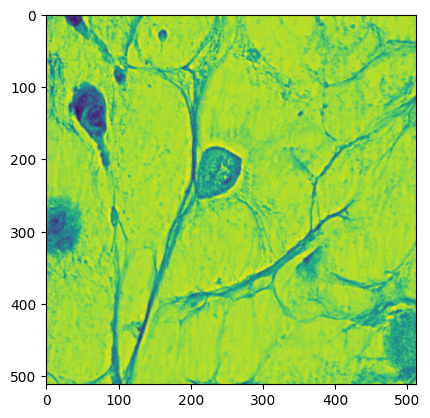

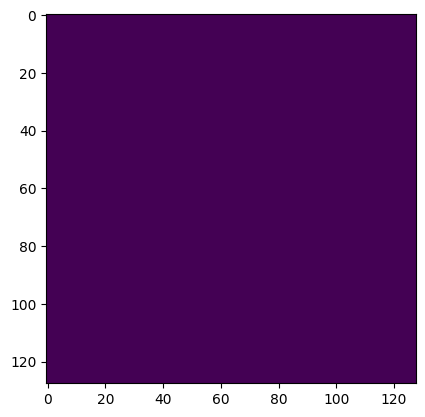

In [18]:
plt.imshow(images[30][0])
plt.show()
plt.imshow(hm[30])

## 3. Model Training

### 3.1 CenterNet Model

#### Define CenterNet model

The model is based on [CenterNet Baseline](https://www.kaggle.com/hocop1/centernet-baseline/data).

In [19]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
            # input is CHW
            diffY = x2.size()[2] - x1.size()[2]
            diffX = x2.size()[3] - x1.size()[3]

            x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                            diffY // 2, diffY - diffY//2))
        else:
            x = x1
        x = self.conv(x)
        return x

class centernet(nn.Module):
    def __init__(self, n_classes=1, model_name="resnet18"):
        super(centernet, self).__init__()

        # Create model backbone
        if model_name == "resnet50":
            basemodel = torchvision.models.resnet50(pretrained=False)
            num_ch = 2048
        elif model_name == "resnet34":
            basemodel = torchvision.models.resnet34(pretrained=False)
            num_ch = 512
        elif model_name == "resnet18":
            basemodel = torchvision.models.resnet18(pretrained=False)
            num_ch = 512

        # Remove the last two layers (average pooling and linear layer)
        self.base_model = nn.Sequential(*list(basemodel.children())[:-2])

        self.up1 = up(num_ch, 512)
        self.up2 = up(512, 256)
        self.up3 = up(256, 256)

        # Output classification
        self.outc = nn.Conv2d(256, n_classes, 1)

        # Output residue
        self.outr = nn.Conv2d(256, 2, 1)

    def forward(self, x):
        x = self.base_model(x)
        # Add positional info
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        outc = self.outc(x)
        outc = torch.sigmoid(outc)
        outr = self.outr(x)
        return outc, outr

#### Define Loss

In [20]:
# From centernet repo
# Modified focal loss to detect object centers via heatmap
def neg_loss(pred, gt, pos_gamma=2, neg_gamma=4):
  ''' Modified focal loss. Exactly the same as CornerNet.
      Runs faster and costs a little bit more memory
      Args:
      pred: (B, 1, H, W)
      gt: (B, 1, H, W)
      pos_gamma: focusing parameter for positive examples
      neg_gamma: focusing parameter for negative examples
    '''

  pred = pred.unsqueeze(1).float()
  gt = gt.unsqueeze(1).float()

  pos_inds = gt.eq(1).float() # Locations where there is a true object center
  neg_inds = gt.lt(1).float()  # All other pixels
  neg_weights = torch.pow(1 - gt, 4) # Higher weight for pixels farther from center

  loss = 0

  pos_loss = torch.log(pred + 1e-12) * torch.pow(1 - pred, pos_gamma) * pos_inds
  neg_loss = torch.log(1 - pred + 1e-12) * torch.pow(pred, neg_gamma) * neg_weights * neg_inds

  # pos_loss = torch.log(pred + 1e-12) * torch.pow(1 - pred, 3) * pos_inds
  # neg_loss = torch.log(1 - pred + 1e-12) * torch.pow(pred, 3) * neg_weights * neg_inds

  num_pos  = pos_inds.float().sum()
  num_pos = torch.clamp(num_pos, min=1.0)

  pos_loss = pos_loss.sum()
  neg_loss = neg_loss.sum()

  if num_pos == 0:
    loss = loss - neg_loss
  else:
    loss = loss - (pos_loss + neg_loss) / num_pos

  return loss

# Smooth L1 regression loss for offsets, widths, etc.
def _reg_loss(regr, gt_regr, mask):
  ''' L1 regression loss
    Arguments:
      regr (batch x max_objects x dim)
      gt_regr (batch x max_objects x dim)
      mask (batch x max_objects)
  '''
  num = mask.float().sum()
  #print(gt_regr.size())
  mask = mask.sum(1).unsqueeze(1).expand_as(gt_regr)
  #print(mask.size())

  regr = regr * mask
  gt_regr = gt_regr * mask

  regr_loss = nn.functional.smooth_l1_loss(regr, gt_regr, size_average=False)
  regr_loss = regr_loss / (num + 1e-4)

  return regr_loss


def centerloss(prediction, mask, regr, weight=0.4, size_average=True, eps=1e-6):
    """
    Combines heatmap focal loss and regression L1 loss into a total loss.

    Args:
        prediction: (B, 3, H, W) where [:, 0] = heatmap, [:, 1:] = regr
        mask: (B, H, W) – binary mask for object centers
        regr: (B, 2, H, W) – regression ground truth
        weight: float – weight of regression loss
        size_average: bool – average the final loss across batch
        eps: float – small number to avoid division by zero

    Returns:
        total_loss, mask_loss, regr_loss
    """

    # Heatmap and regression prediction
    pred_mask = torch.sigmoid(prediction[:, 0])  # (B, H, W)
    pred_regr = prediction[:, 1:]                # (B, 2, H, W)

    # Heatmap focal loss
    mask_loss = neg_loss(pred_mask, mask)

    # Regression L1 loss, masked only where mask == 1
    # Use broadcasting: (B, 2, H, W) * (B, 1, H, W)
    mask_exp = mask.unsqueeze(1)  # (B, 1, H, W)
    regr_loss = torch.abs(pred_regr - regr) * mask_exp
    regr_loss = regr_loss.sum(dim=(1, 2, 3)) / (mask_exp.sum(dim=(1, 2, 3)) + eps)
    regr_loss = regr_loss.mean()

    # Combine
    total_loss = mask_loss * weight + regr_loss * (1 - weight)

    if not size_average:
        total_loss *= prediction.shape[0]

    return total_loss, mask_loss, regr_loss


### 3.2 Train function

In [21]:
def train(epoch):
    # Set model to training mode
    model.train()
    print(f'epochs {epoch + 1}/{epochs}')

    running_loss = 0.0 # Accumulate total loss over batches
    running_mask = 0.0 # Accumulate mask (heatmap) loss over batches
    running_regr = 0.0 # Accumulate regression loss over batches
    t = tqdm(train_loader) # Wrap the DataLoader in tqdm for progress bar

    # Iterate over batches
    for idx, (img, hm_gt, regr_gt, _) in enumerate(t):

        # Move batch tensors to the device (GPU or CPU)
        img = img.to(device)
        hm_gt = hm_gt.to(device)
        regr_gt = regr_gt.to(device)

        # Reset gradients for new batch
        optimizer.zero_grad(set_to_none=True)

         # Forward pass: predict heatmap and regression outputs
        hm_pred, regr_pred = model(img)

        # Concatenate heatmap and regression predictions along channel dimension
        preds = torch.cat((hm_pred, regr_pred), dim=1)

        # Compute combined loss (total, mask, and regression)
        loss, mask_loss, regr_loss = centerloss(preds, hm_gt, regr_gt)

         # Visualization: plot the GT and predicted heatmap for only first batch of epoch
        if idx == 0 and (epoch % 5 == 0 or epoch == 0):
            plt.subplot(1, 2, 1)
            plt.imshow(hm_gt[0].squeeze().cpu().detach().numpy(), cmap='hot')
            plt.title('GT Heatmap')

            plt.subplot(1, 2, 2)
            plt.imshow(torch.sigmoid(hm_pred[0]).squeeze().cpu().detach().numpy(), cmap='hot')
            plt.title('Pred Heatmap')
            plt.show()

        # Backpropagation: compute gradients
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update model weights
        optimizer.step()

        # Accumulate loss values for reporting
        running_loss += loss.item()
        running_mask += mask_loss.item()
        running_regr += regr_loss.item()

         # Compute running average losses for progress bar display
        avg_loss = running_loss / (idx + 1)
        avg_mask = running_mask / (idx + 1)
        avg_regr = running_regr / (idx + 1)

        # Update tqdm progress bar with current average losses
        t.set_postfix(loss=avg_loss, mask=avg_mask, regr=avg_regr)

    # Average losses over the entire epoch after training completes
    print(f'Train loss : {running_loss/len(train_loader):.4f}')
    print(f'Train mask loss : {running_mask/len(train_loader):.4f}')
    print(f'Train regr loss : {running_regr/len(train_loader):.4f}')

    # Save epoch logs for tracking training progress later
    logs.append({
        'epoch': epoch + 1,
        'lr': optimizer.state_dict()['param_groups'][0]['lr'],
        'loss': running_loss / len(train_loader),
        'mask': running_mask / len(train_loader),
        'regr': running_regr / len(train_loader)
    })

    # Run validation after training epoch
    val_loss, val_mask, val_regr = validate()
    logs_eval.append({
        'epoch': epoch + 1,
        'loss': val_loss,
        'mask': val_mask,
        'regr': val_regr
    })

def validate():
    # Set model to evaluation mode
    model.eval()
    running_loss = 0.0
    running_mask = 0.0
    running_regr = 0.0

    # Disable gradient calculations
    with torch.no_grad():  # disable gradient calculations
        for idx, (img, hm_gt, regr_gt, _) in enumerate(val_loader):
            img = img.to(device)
            hm_gt = hm_gt.to(device)
            regr_gt = regr_gt.to(device)

            hm_pred, regr_pred = model(img)

            # Visualization: plot the GT and predicted heatmap for only first batch of epoch
            if idx == 0 and (epoch % 5 == 0 or epoch == 0):
                plt.subplot(1, 2, 1)
                plt.imshow(hm_gt[0].squeeze().cpu().detach().numpy(), cmap='hot')
                plt.title('GT Heatmap')

                plt.subplot(1, 2, 2)
                plt.imshow(torch.sigmoid(hm_pred[0]).squeeze().cpu().detach().numpy(), cmap='hot')
                plt.title('Pred Heatmap')
                plt.show()

            preds = torch.cat((hm_pred, regr_pred), dim=1)
            loss, mask_loss, regr_loss = centerloss(preds, hm_gt, regr_gt)

            running_loss += loss.item()
            running_mask += mask_loss.item()
            running_regr += regr_loss.item()

    avg_loss = running_loss / len(val_loader)
    avg_mask = running_mask / len(val_loader)
    avg_regr = running_regr / len(val_loader)

    print(f'Validation loss : {avg_loss:.4f}')
    print(f'Validation mask loss : {avg_mask:.4f}')
    print(f'Validation regr loss : {avg_regr:.4f}')

    # Update learning rate scheduler
    scheduler.step(avg_loss)

    return avg_loss, avg_mask, avg_regr

### 3.3 Train model

In [22]:
MODEL_PATH = ''
TRAIN = True

#### RMSprop and RestNet34

In [ ]:
# Check if it runs correctly
model = centernet(model_name='resnet34')
model(torch.rand(1,3,512,512))[0].size()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([1, 1, 128, 128])

In [ ]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)
# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

epochs 1/50


  0%|          | 0/68 [00:00<?, ?it/s]

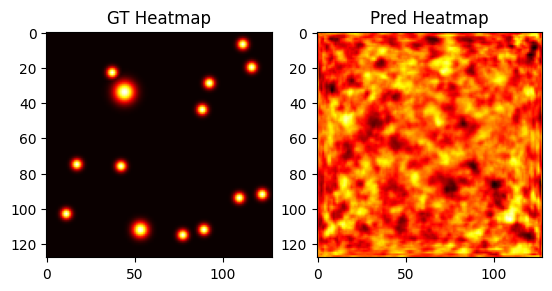

Train loss : 58.2167
Train mask loss : 145.3272
Train regr loss : 0.1431


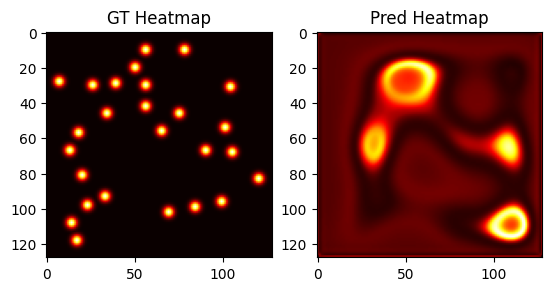

Validation loss : 68.4711
Validation mask loss : 167.3076
Validation regr loss : 2.5802
epochs 2/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 47.0269
Train mask loss : 117.4133
Train regr loss : 0.1025
Validation loss : 41.6854
Validation mask loss : 103.9166
Validation regr loss : 0.1980
epochs 3/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 43.2198
Train mask loss : 107.8983
Train regr loss : 0.1007
Validation loss : 39.6689
Validation mask loss : 99.0220
Validation regr loss : 0.1002
epochs 4/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 43.0669
Train mask loss : 107.5188
Train regr loss : 0.0990
Validation loss : 39.1569
Validation mask loss : 97.7409
Validation regr loss : 0.1010
epochs 5/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.1272
Train mask loss : 105.1613
Train regr loss : 0.1045
Validation loss : 38.9352
Validation mask loss : 97.1870
Validation regr loss : 0.1007
epochs 6/50


  0%|          | 0/68 [00:00<?, ?it/s]

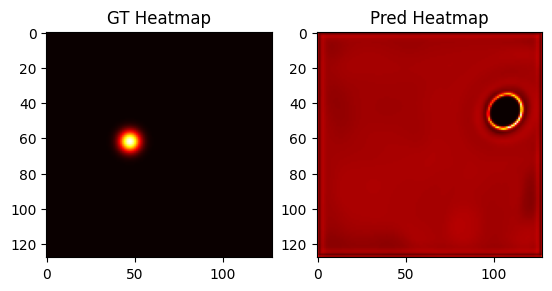

Train loss : 42.2694
Train mask loss : 105.5110
Train regr loss : 0.1083


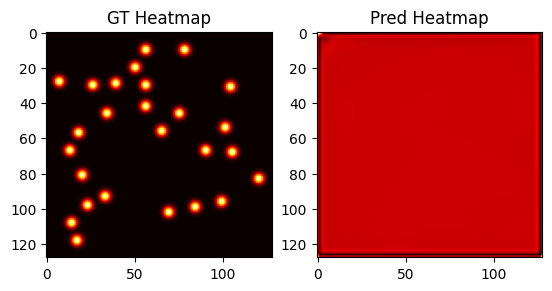

Validation loss : 38.8917
Validation mask loss : 97.0720
Validation regr loss : 0.1047
epochs 7/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.1511
Train mask loss : 105.2229
Train regr loss : 0.1032
Validation loss : 38.8417
Validation mask loss : 96.9463
Validation regr loss : 0.1053
epochs 8/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.9878
Train mask loss : 104.8204
Train regr loss : 0.0994
Validation loss : 38.8168
Validation mask loss : 96.8179
Validation regr loss : 0.1494
epochs 9/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.9115
Train mask loss : 104.6293
Train regr loss : 0.0996
Validation loss : 38.7815
Validation mask loss : 96.7917
Validation regr loss : 0.1081
epochs 10/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.3806
Train mask loss : 105.7940
Train regr loss : 0.1050
Validation loss : 38.7925
Validation mask loss : 96.7797
Validation regr loss : 0.1343
epochs 11/50


  0%|          | 0/68 [00:00<?, ?it/s]

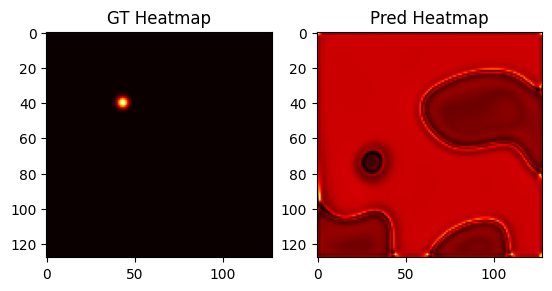

Train loss : 42.1726
Train mask loss : 105.2812
Train regr loss : 0.1001


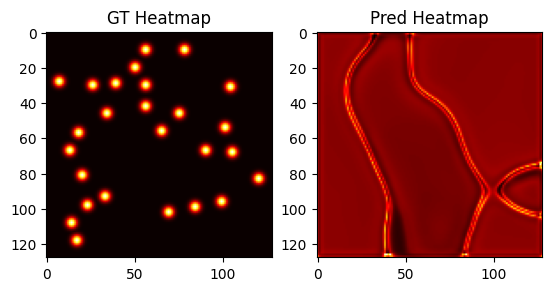

Validation loss : 38.7722
Validation mask loss : 96.7674
Validation regr loss : 0.1088
epochs 12/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.4956
Train mask loss : 106.0915
Train regr loss : 0.0984
Validation loss : 38.7680
Validation mask loss : 96.7547
Validation regr loss : 0.1103
epochs 13/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.5721
Train mask loss : 106.2819
Train regr loss : 0.0989
Validation loss : 38.7605
Validation mask loss : 96.7492
Validation regr loss : 0.1015
epochs 14/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.1196
Train mask loss : 105.1556
Train regr loss : 0.0956
Validation loss : 38.7588
Validation mask loss : 96.7442
Validation regr loss : 0.1018
epochs 15/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.9328
Train mask loss : 104.6888
Train regr loss : 0.0954
Validation loss : 38.7572
Validation mask loss : 96.7442
Validation regr loss : 0.0991
epochs 16/50


  0%|          | 0/68 [00:00<?, ?it/s]

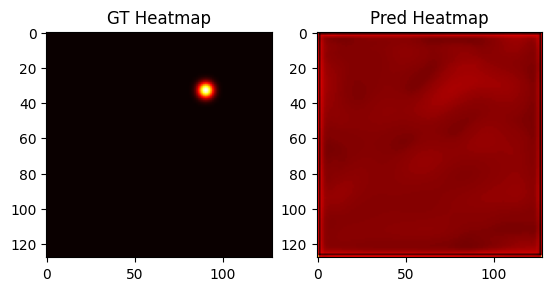

Train loss : 42.0699
Train mask loss : 105.0332
Train regr loss : 0.0943


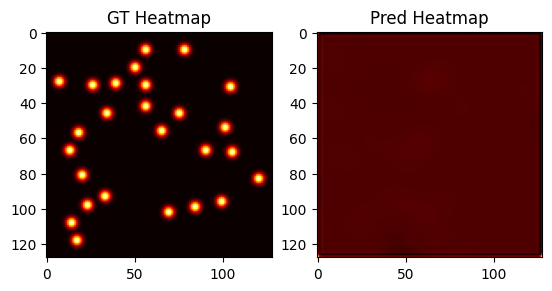

Validation loss : 38.7676
Validation mask loss : 96.7405
Validation regr loss : 0.1191
epochs 17/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.1440
Train mask loss : 105.2180
Train regr loss : 0.0947
Validation loss : 38.7549
Validation mask loss : 96.7397
Validation regr loss : 0.0984
epochs 18/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.9168
Train mask loss : 104.6461
Train regr loss : 0.0972
Validation loss : 38.7584
Validation mask loss : 96.7379
Validation regr loss : 0.1054
epochs 19/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.2071
Train mask loss : 105.3696
Train regr loss : 0.0987
Validation loss : 38.7539
Validation mask loss : 96.7365
Validation regr loss : 0.0989
epochs 20/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.9710
Train mask loss : 104.7878
Train regr loss : 0.0931
Validation loss : 38.7529
Validation mask loss : 96.7357
Validation regr loss : 0.0978
epochs 21/50


  0%|          | 0/68 [00:00<?, ?it/s]

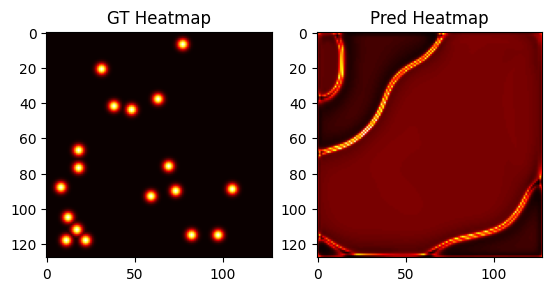

Train loss : 42.2023
Train mask loss : 105.3657
Train regr loss : 0.0933


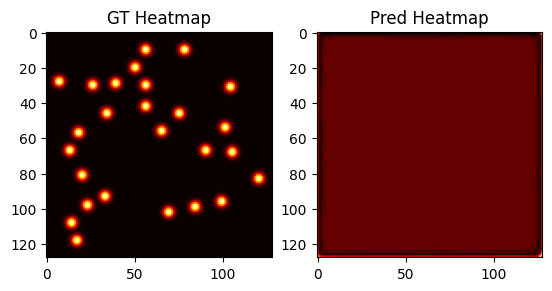

Validation loss : 38.7555
Validation mask loss : 96.7356
Validation regr loss : 0.1021
epochs 22/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.0246
Train mask loss : 104.9249
Train regr loss : 0.0911
Validation loss : 38.7524
Validation mask loss : 96.7352
Validation regr loss : 0.0972
epochs 23/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.0820
Train mask loss : 105.0686
Train regr loss : 0.0909
Validation loss : 38.7636
Validation mask loss : 96.7353
Validation regr loss : 0.1157
epochs 24/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.9976
Train mask loss : 104.8584
Train regr loss : 0.0904
Validation loss : 38.7517
Validation mask loss : 96.7351
Validation regr loss : 0.0962
epochs 25/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.7706
Train mask loss : 104.2916
Train regr loss : 0.0899
Validation loss : 38.7513
Validation mask loss : 96.7349
Validation regr loss : 0.0956
epochs 26/50


  0%|          | 0/68 [00:00<?, ?it/s]

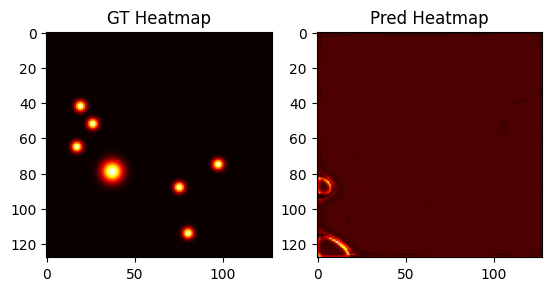

Train loss : 41.9999
Train mask loss : 104.8672
Train regr loss : 0.0884


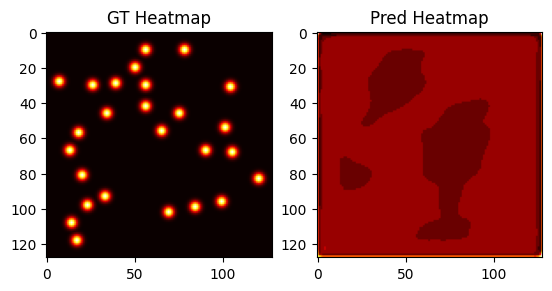

Validation loss : 38.7493
Validation mask loss : 96.7349
Validation regr loss : 0.0922
epochs 27/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.3039
Train mask loss : 105.6279
Train regr loss : 0.0880
Validation loss : 38.7493
Validation mask loss : 96.7348
Validation regr loss : 0.0924
epochs 28/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.7005
Train mask loss : 104.1205
Train regr loss : 0.0872
Validation loss : 38.7496
Validation mask loss : 96.7348
Validation regr loss : 0.0928
epochs 29/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.4637
Train mask loss : 106.0295
Train regr loss : 0.0865
Validation loss : 38.7498
Validation mask loss : 96.7347
Validation regr loss : 0.0932
epochs 30/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.1139
Train mask loss : 105.1554
Train regr loss : 0.0861
Validation loss : 38.7497
Validation mask loss : 96.7347
Validation regr loss : 0.0931
epochs 31/50


  0%|          | 0/68 [00:00<?, ?it/s]

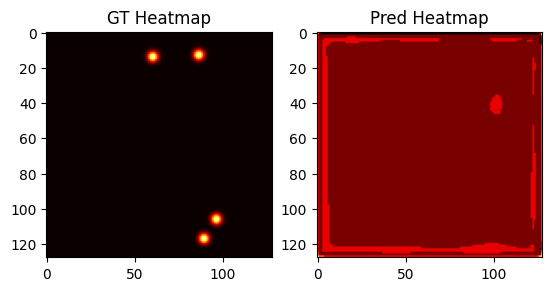

Train loss : 42.1919
Train mask loss : 105.3522
Train regr loss : 0.0851


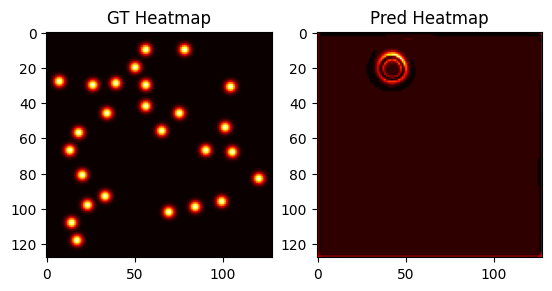

Validation loss : 38.7479
Validation mask loss : 96.7346
Validation regr loss : 0.0900
epochs 32/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.8098
Train mask loss : 104.3982
Train regr loss : 0.0843
Validation loss : 38.7492
Validation mask loss : 96.7346
Validation regr loss : 0.0922
epochs 33/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.8454
Train mask loss : 104.4878
Train regr loss : 0.0839
Validation loss : 38.7495
Validation mask loss : 96.7346
Validation regr loss : 0.0928
epochs 34/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.2282
Train mask loss : 105.4451
Train regr loss : 0.0836
Validation loss : 38.7474
Validation mask loss : 96.7346
Validation regr loss : 0.0893
epochs 35/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.8003
Train mask loss : 104.3767
Train regr loss : 0.0828
Validation loss : 38.7471
Validation mask loss : 96.7346
Validation regr loss : 0.0888
epochs 36/50


  0%|          | 0/68 [00:00<?, ?it/s]

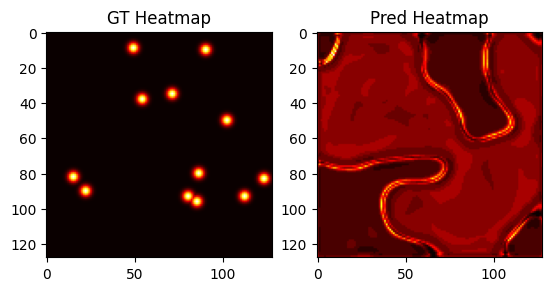

Train loss : 42.0665
Train mask loss : 105.0425
Train regr loss : 0.0824


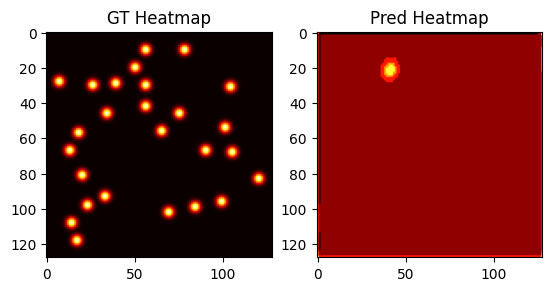

Validation loss : 38.7467
Validation mask loss : 96.7346
Validation regr loss : 0.0881
epochs 37/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.7899
Train mask loss : 104.3514
Train regr loss : 0.0821
Validation loss : 38.7470
Validation mask loss : 96.7346
Validation regr loss : 0.0886
epochs 38/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.6497
Train mask loss : 104.0014
Train regr loss : 0.0820
Validation loss : 38.7464
Validation mask loss : 96.7345
Validation regr loss : 0.0877
epochs 39/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.0737
Train mask loss : 105.0619
Train regr loss : 0.0815
Validation loss : 38.7462
Validation mask loss : 96.7345
Validation regr loss : 0.0873
epochs 40/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.8885
Train mask loss : 104.5992
Train regr loss : 0.0814
Validation loss : 38.7461
Validation mask loss : 96.7345
Validation regr loss : 0.0872
epochs 41/50


  0%|          | 0/68 [00:00<?, ?it/s]

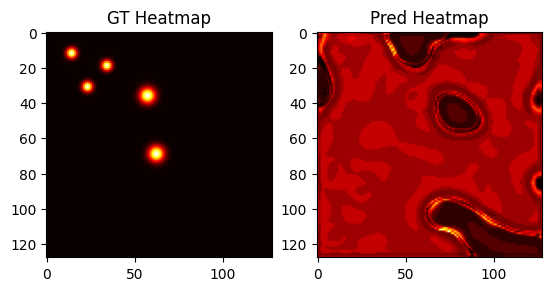

Train loss : 42.6257
Train mask loss : 106.4425
Train regr loss : 0.0812


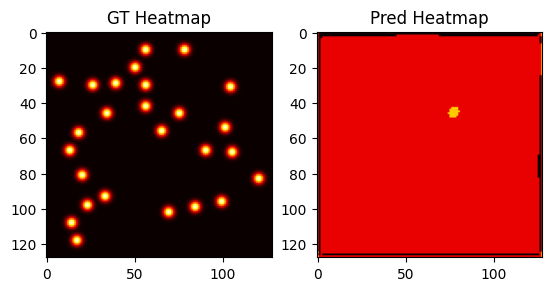

Validation loss : 38.7463
Validation mask loss : 96.7345
Validation regr loss : 0.0875
epochs 42/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.9983
Train mask loss : 104.8742
Train regr loss : 0.0811
Validation loss : 38.7461
Validation mask loss : 96.7345
Validation regr loss : 0.0871
epochs 43/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.8792
Train mask loss : 104.5765
Train regr loss : 0.0810
Validation loss : 38.7459
Validation mask loss : 96.7345
Validation regr loss : 0.0869
epochs 44/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.2858
Train mask loss : 105.5934
Train regr loss : 0.0808
Validation loss : 38.7459
Validation mask loss : 96.7345
Validation regr loss : 0.0869
epochs 45/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.1386
Train mask loss : 105.2253
Train regr loss : 0.0808
Validation loss : 38.7460
Validation mask loss : 96.7345
Validation regr loss : 0.0869
epochs 46/50


  0%|          | 0/68 [00:00<?, ?it/s]

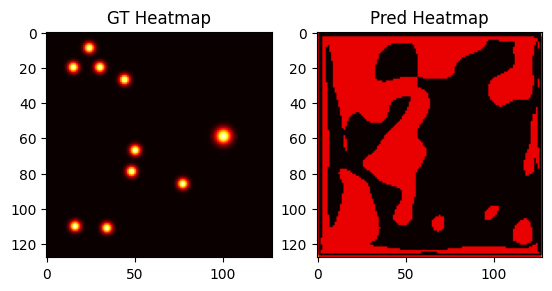

Train loss : 41.8686
Train mask loss : 104.5506
Train regr loss : 0.0807


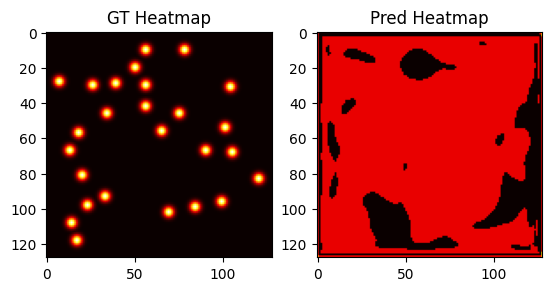

Validation loss : 38.7460
Validation mask loss : 96.7345
Validation regr loss : 0.0869
epochs 47/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.5234
Train mask loss : 106.1876
Train regr loss : 0.0806
Validation loss : 38.7459
Validation mask loss : 96.7345
Validation regr loss : 0.0868
epochs 48/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.7475
Train mask loss : 104.2478
Train regr loss : 0.0806
Validation loss : 38.7459
Validation mask loss : 96.7345
Validation regr loss : 0.0868
epochs 49/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.9429
Train mask loss : 104.7366
Train regr loss : 0.0805
Validation loss : 38.7458
Validation mask loss : 96.7345
Validation regr loss : 0.0867
epochs 50/50


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.8539
Train mask loss : 104.5140
Train regr loss : 0.0805
Validation loss : 38.7458
Validation mask loss : 96.7345
Validation regr loss : 0.0867


In [ ]:
epochs=50
logs = []
logs_eval = []

if TRAIN:
    for epoch in range(epochs):
        train(epoch)
else:
    model.load_state_dict(torch.load(MODEL_PATH))

#### AdamW and RestNet34

In [23]:
# Check if it runs correctly
model = centernet(model_name='resnet34')
model(torch.rand(1,3,512,512))[0].size()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([1, 1, 128, 128])

In [24]:
# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

epochs 1/60


  0%|          | 0/68 [00:00<?, ?it/s]

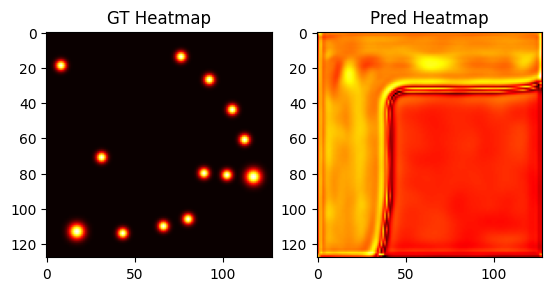

Train loss : 44.1955
Train mask loss : 110.3347
Train regr loss : 0.1027


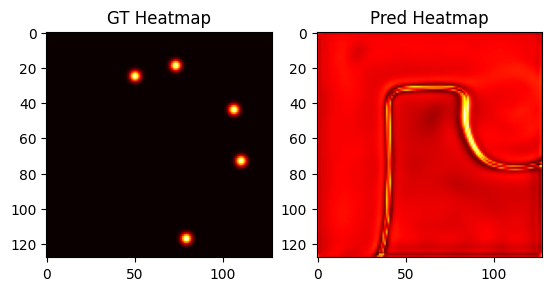

Validation loss : 39.0678
Validation mask loss : 97.2524
Validation regr loss : 0.2780
epochs 2/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 43.6065
Train mask loss : 108.8627
Train regr loss : 0.1023
Validation loss : 38.2321
Validation mask loss : 95.3720
Validation regr loss : 0.1388
epochs 3/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.6696
Train mask loss : 106.5217
Train regr loss : 0.1015
Validation loss : 37.9373
Validation mask loss : 94.6766
Validation regr loss : 0.1112
epochs 4/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.6495
Train mask loss : 106.4761
Train regr loss : 0.0984
Validation loss : 37.7803
Validation mask loss : 94.2772
Validation regr loss : 0.1157
epochs 5/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.1916
Train mask loss : 105.3349
Train regr loss : 0.0961
Validation loss : 37.7132
Validation mask loss : 94.1223
Validation regr loss : 0.1072
epochs 6/60


  0%|          | 0/68 [00:00<?, ?it/s]

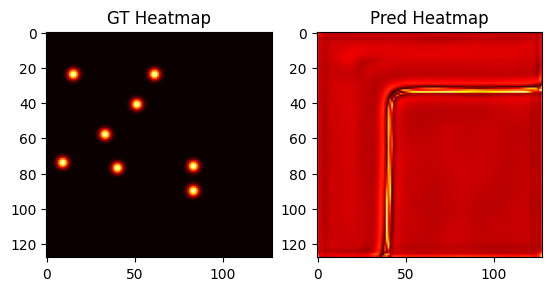

Train loss : 42.0286
Train mask loss : 104.9300
Train regr loss : 0.0943


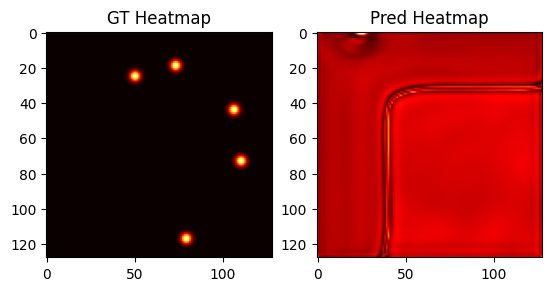

Validation loss : 37.6941
Validation mask loss : 94.0832
Validation regr loss : 0.1014
epochs 7/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.1018
Train mask loss : 105.1171
Train regr loss : 0.0916
Validation loss : 37.6789
Validation mask loss : 94.0467
Validation regr loss : 0.1003
epochs 8/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.0501
Train mask loss : 104.9930
Train regr loss : 0.0882
Validation loss : 37.6693
Validation mask loss : 94.0262
Validation regr loss : 0.0981
epochs 9/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.4633
Train mask loss : 106.0290
Train regr loss : 0.0862
Validation loss : 37.6642
Validation mask loss : 94.0166
Validation regr loss : 0.0960
epochs 10/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.2978
Train mask loss : 105.6176
Train regr loss : 0.0846
Validation loss : 37.6611
Validation mask loss : 94.0075
Validation regr loss : 0.0969
epochs 11/60


  0%|          | 0/68 [00:00<?, ?it/s]

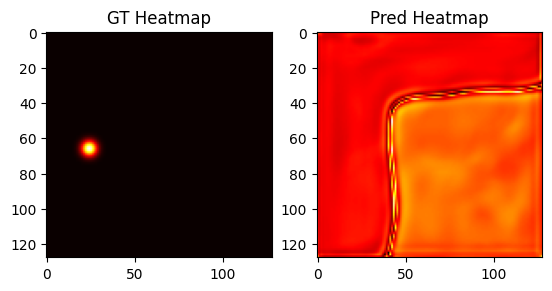

Train loss : 41.6678
Train mask loss : 104.0452
Train regr loss : 0.0828


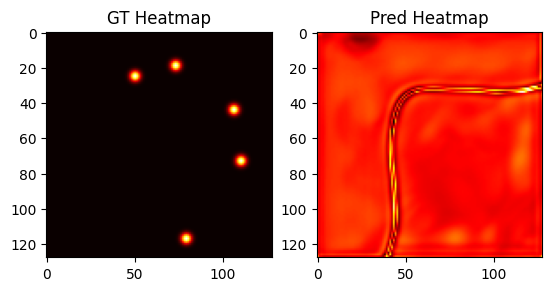

Validation loss : 37.6565
Validation mask loss : 94.0004
Validation regr loss : 0.0938
epochs 12/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.0458
Train mask loss : 104.9932
Train regr loss : 0.0809
Validation loss : 37.6550
Validation mask loss : 93.9973
Validation regr loss : 0.0934
epochs 13/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.9298
Train mask loss : 104.7059
Train regr loss : 0.0790
Validation loss : 37.6501
Validation mask loss : 93.9927
Validation regr loss : 0.0883
epochs 14/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.8489
Train mask loss : 104.5073
Train regr loss : 0.0766
Validation loss : 37.6499
Validation mask loss : 93.9893
Validation regr loss : 0.0903
epochs 15/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.6429
Train mask loss : 106.4963
Train regr loss : 0.0739
Validation loss : 37.6450
Validation mask loss : 93.9874
Validation regr loss : 0.0835
epochs 16/60


  0%|          | 0/68 [00:00<?, ?it/s]

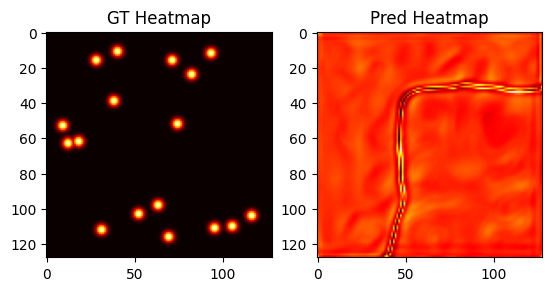

Train loss : 41.7535
Train mask loss : 104.2775
Train regr loss : 0.0708


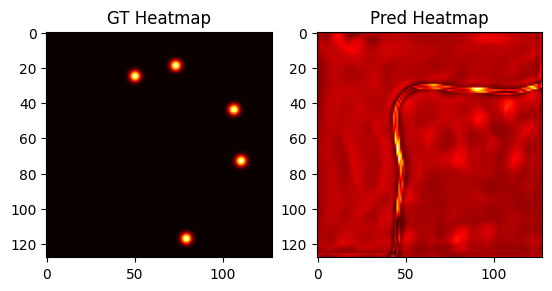

Validation loss : 37.6423
Validation mask loss : 93.9856
Validation regr loss : 0.0801
epochs 17/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.3746
Train mask loss : 105.8381
Train regr loss : 0.0657
Validation loss : 37.6383
Validation mask loss : 93.9832
Validation regr loss : 0.0751
epochs 18/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.6050
Train mask loss : 106.4206
Train regr loss : 0.0613
Validation loss : 37.6367
Validation mask loss : 93.9820
Validation regr loss : 0.0732
epochs 19/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.1714
Train mask loss : 105.3447
Train regr loss : 0.0559
Validation loss : 37.6374
Validation mask loss : 93.9804
Validation regr loss : 0.0754
epochs 20/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.6902
Train mask loss : 106.6464
Train regr loss : 0.0527
Validation loss : 37.6335
Validation mask loss : 93.9794
Validation regr loss : 0.0695
epochs 21/60


  0%|          | 0/68 [00:00<?, ?it/s]

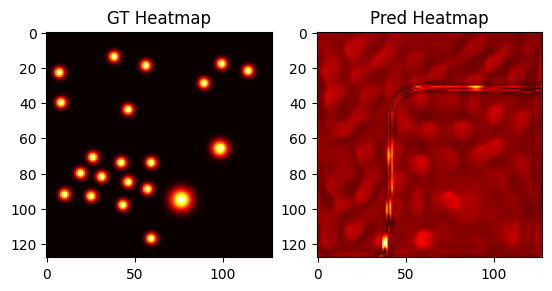

Train loss : 42.7268
Train mask loss : 106.7442
Train regr loss : 0.0486


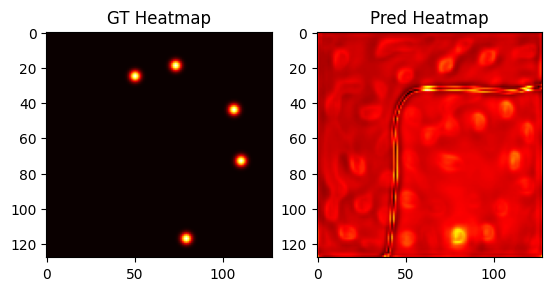

Validation loss : 37.6293
Validation mask loss : 93.9787
Validation regr loss : 0.0631
epochs 22/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.9068
Train mask loss : 104.6984
Train regr loss : 0.0458
Validation loss : 37.6291
Validation mask loss : 93.9774
Validation regr loss : 0.0636
epochs 23/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.9807
Train mask loss : 104.8868
Train regr loss : 0.0433
Validation loss : 37.6274
Validation mask loss : 93.9776
Validation regr loss : 0.0606
epochs 24/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.1876
Train mask loss : 105.4073
Train regr loss : 0.0412
Validation loss : 37.6251
Validation mask loss : 93.9768
Validation regr loss : 0.0573
epochs 25/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.9894
Train mask loss : 104.9166
Train regr loss : 0.0379
Validation loss : 37.6235
Validation mask loss : 93.9760
Validation regr loss : 0.0552
epochs 26/60


  0%|          | 0/68 [00:00<?, ?it/s]

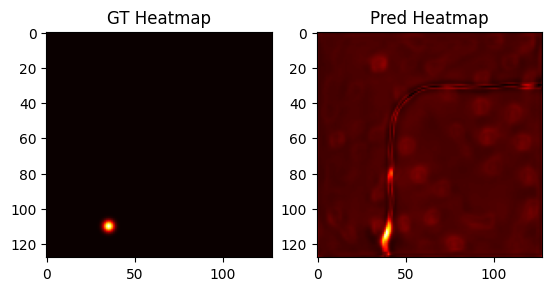

Train loss : 42.3823
Train mask loss : 105.9015
Train regr loss : 0.0362


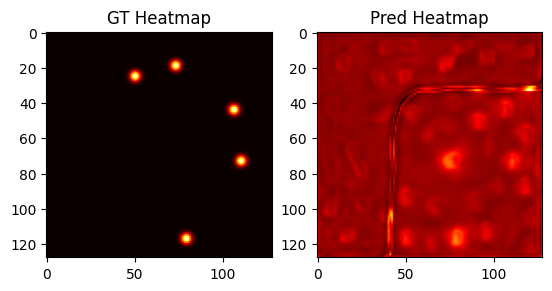

Validation loss : 37.6226
Validation mask loss : 93.9758
Validation regr loss : 0.0538
epochs 27/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.2034
Train mask loss : 105.4575
Train regr loss : 0.0341
Validation loss : 37.6216
Validation mask loss : 93.9752
Validation regr loss : 0.0526
epochs 28/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.4670
Train mask loss : 106.1173
Train regr loss : 0.0334
Validation loss : 37.6183
Validation mask loss : 93.9749
Validation regr loss : 0.0473
epochs 29/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.9018
Train mask loss : 104.7040
Train regr loss : 0.0336
Validation loss : 37.6211
Validation mask loss : 93.9745
Validation regr loss : 0.0521
epochs 30/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.7929
Train mask loss : 104.4354
Train regr loss : 0.0313
Validation loss : 37.6206
Validation mask loss : 93.9743
Validation regr loss : 0.0515
epochs 31/60


  0%|          | 0/68 [00:00<?, ?it/s]

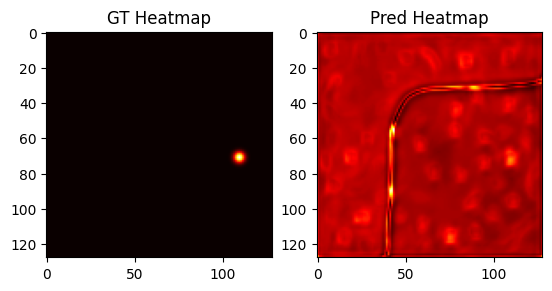

Train loss : 41.9015
Train mask loss : 104.7095
Train regr loss : 0.0295


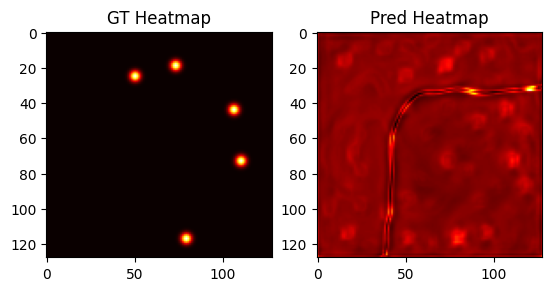

Validation loss : 37.6187
Validation mask loss : 93.9739
Validation regr loss : 0.0485
epochs 32/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.9831
Train mask loss : 104.9135
Train regr loss : 0.0294
Validation loss : 37.6194
Validation mask loss : 93.9737
Validation regr loss : 0.0499
epochs 33/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.2208
Train mask loss : 105.5148
Train regr loss : 0.0249
Validation loss : 37.6143
Validation mask loss : 93.9735
Validation regr loss : 0.0416
epochs 34/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.2834
Train mask loss : 105.6781
Train regr loss : 0.0202
Validation loss : 37.6120
Validation mask loss : 93.9734
Validation regr loss : 0.0377
epochs 35/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.4525
Train mask loss : 106.1041
Train regr loss : 0.0182
Validation loss : 37.6116
Validation mask loss : 93.9732
Validation regr loss : 0.0372
epochs 36/60


  0%|          | 0/68 [00:00<?, ?it/s]

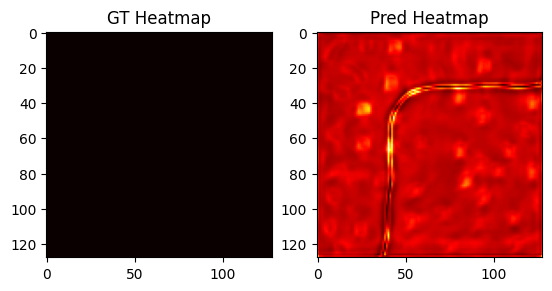

Train loss : 42.1243
Train mask loss : 105.2854
Train regr loss : 0.0170


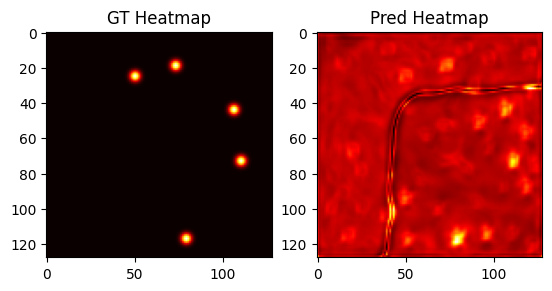

Validation loss : 37.6106
Validation mask loss : 93.9731
Validation regr loss : 0.0357
epochs 37/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.0784
Train mask loss : 105.1726
Train regr loss : 0.0156
Validation loss : 37.6097
Validation mask loss : 93.9730
Validation regr loss : 0.0342
epochs 38/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.8955
Train mask loss : 104.7147
Train regr loss : 0.0160
Validation loss : 37.6091
Validation mask loss : 93.9728
Validation regr loss : 0.0332
epochs 39/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.3829
Train mask loss : 105.9348
Train regr loss : 0.0150
Validation loss : 37.6126
Validation mask loss : 93.9727
Validation regr loss : 0.0391
epochs 40/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.4246
Train mask loss : 106.0393
Train regr loss : 0.0148
Validation loss : 37.6087
Validation mask loss : 93.9727
Validation regr loss : 0.0327
epochs 41/60


  0%|          | 0/68 [00:00<?, ?it/s]

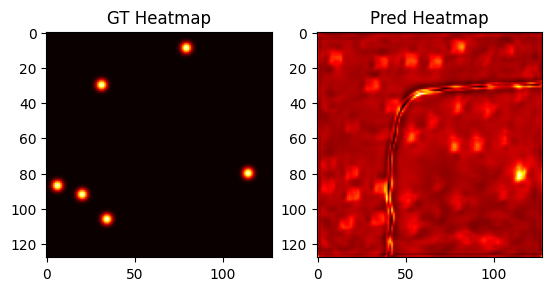

Train loss : 41.9942
Train mask loss : 104.9645
Train regr loss : 0.0139


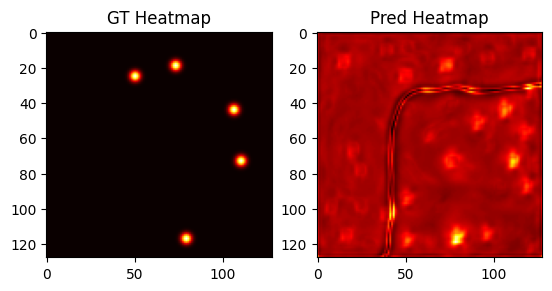

Validation loss : 37.6096
Validation mask loss : 93.9724
Validation regr loss : 0.0344
epochs 42/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.3350
Train mask loss : 105.8192
Train regr loss : 0.0122
Validation loss : 37.6072
Validation mask loss : 93.9724
Validation regr loss : 0.0304
epochs 43/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.3625
Train mask loss : 105.8901
Train regr loss : 0.0108
Validation loss : 37.6060
Validation mask loss : 93.9724
Validation regr loss : 0.0284
epochs 44/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.1709
Train mask loss : 105.4124
Train regr loss : 0.0099
Validation loss : 37.6061
Validation mask loss : 93.9723
Validation regr loss : 0.0286
epochs 45/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.3639
Train mask loss : 105.8947
Train regr loss : 0.0100
Validation loss : 37.6058
Validation mask loss : 93.9723
Validation regr loss : 0.0281
epochs 46/60


  0%|          | 0/68 [00:00<?, ?it/s]

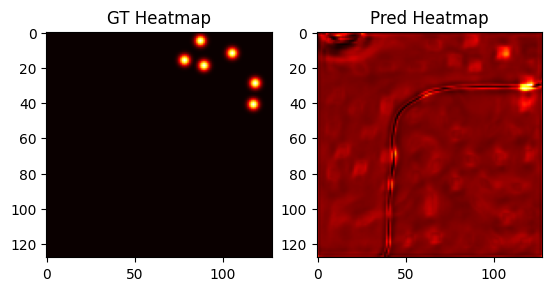

Train loss : 41.8303
Train mask loss : 104.5617
Train regr loss : 0.0094


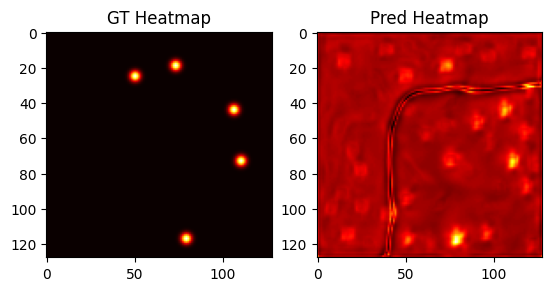

Validation loss : 37.6058
Validation mask loss : 93.9722
Validation regr loss : 0.0282
epochs 47/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.1472
Train mask loss : 105.3533
Train regr loss : 0.0098
Validation loss : 37.6054
Validation mask loss : 93.9721
Validation regr loss : 0.0275
epochs 48/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.1878
Train mask loss : 105.4548
Train regr loss : 0.0097
Validation loss : 37.6063
Validation mask loss : 93.9720
Validation regr loss : 0.0291
epochs 49/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.4434
Train mask loss : 106.0937
Train regr loss : 0.0099
Validation loss : 37.6049
Validation mask loss : 93.9721
Validation regr loss : 0.0268
epochs 50/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.9196
Train mask loss : 104.7861
Train regr loss : 0.0086
Validation loss : 37.6047
Validation mask loss : 93.9720
Validation regr loss : 0.0265
epochs 51/60


  0%|          | 0/68 [00:00<?, ?it/s]

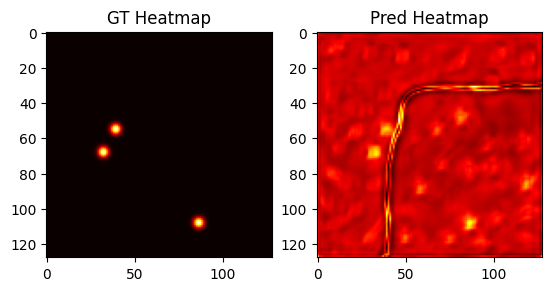

Train loss : 41.8917
Train mask loss : 104.7170
Train regr loss : 0.0082


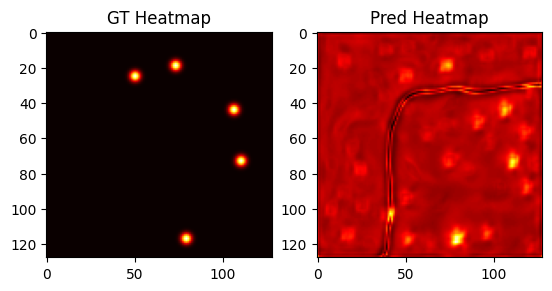

Validation loss : 37.6048
Validation mask loss : 93.9720
Validation regr loss : 0.0267
epochs 52/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.9931
Train mask loss : 104.9707
Train regr loss : 0.0079
Validation loss : 37.6047
Validation mask loss : 93.9719
Validation regr loss : 0.0265
epochs 53/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.0571
Train mask loss : 105.1306
Train regr loss : 0.0081
Validation loss : 37.6045
Validation mask loss : 93.9719
Validation regr loss : 0.0263
epochs 54/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.0820
Train mask loss : 105.1936
Train regr loss : 0.0077
Validation loss : 37.6042
Validation mask loss : 93.9719
Validation regr loss : 0.0258
epochs 55/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.1334
Train mask loss : 105.3226
Train regr loss : 0.0073
Validation loss : 37.6044
Validation mask loss : 93.9719
Validation regr loss : 0.0260
epochs 56/60


  0%|          | 0/68 [00:00<?, ?it/s]

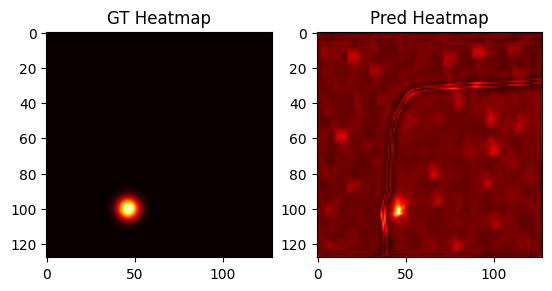

Train loss : 42.2069
Train mask loss : 105.5064
Train regr loss : 0.0072


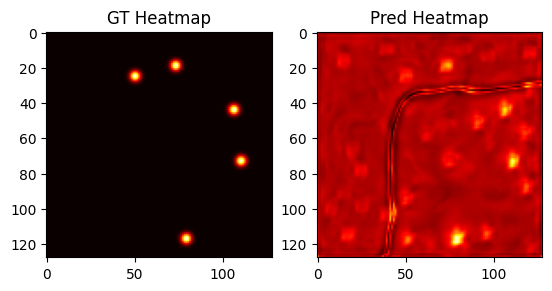

Validation loss : 37.6042
Validation mask loss : 93.9719
Validation regr loss : 0.0257
epochs 57/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.9444
Train mask loss : 104.8500
Train regr loss : 0.0074
Validation loss : 37.6041
Validation mask loss : 93.9718
Validation regr loss : 0.0256
epochs 58/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.5487
Train mask loss : 106.3611
Train regr loss : 0.0070
Validation loss : 37.6041
Validation mask loss : 93.9718
Validation regr loss : 0.0257
epochs 59/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.9798
Train mask loss : 104.9391
Train regr loss : 0.0069
Validation loss : 37.6041
Validation mask loss : 93.9718
Validation regr loss : 0.0257
epochs 60/60


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.9622
Train mask loss : 107.3947
Train regr loss : 0.0071
Validation loss : 37.6041
Validation mask loss : 93.9718
Validation regr loss : 0.0257


In [26]:
epochs=60
logs = []
logs_eval = []

if TRAIN:
    for epoch in range(epochs):
        train(epoch)
else:
    model.load_state_dict(torch.load(MODEL_PATH))

#### Adam and RestNet34

In [27]:
# Check if it runs correctly
model = centernet(model_name='resnet34')
model(torch.rand(1,3,512,512))[0].size()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([1, 1, 128, 128])

In [28]:
# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

epochs 1/80


  0%|          | 0/68 [00:00<?, ?it/s]

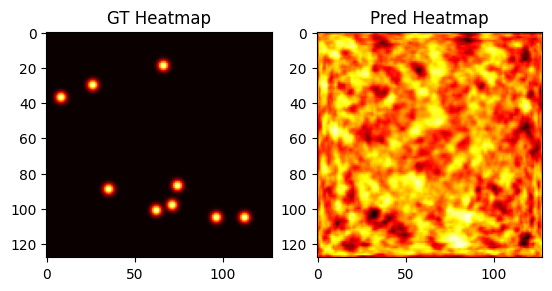

Train loss : 72.8727
Train mask loss : 181.6651
Train regr loss : 0.3445


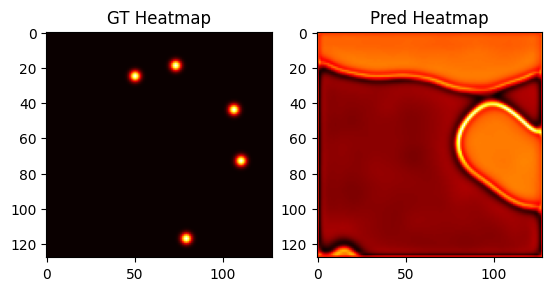

Validation loss : 52.0219
Validation mask loss : 129.8655
Validation regr loss : 0.1261
epochs 2/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 57.9345
Train mask loss : 144.6722
Train regr loss : 0.1094
Validation loss : 150.5413
Validation mask loss : 376.1566
Validation regr loss : 0.1310
epochs 3/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 51.0564
Train mask loss : 127.4945
Train regr loss : 0.0976
Validation loss : 45.1596
Validation mask loss : 112.7081
Validation regr loss : 0.1273
epochs 4/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 48.2754
Train mask loss : 120.5403
Train regr loss : 0.0987
Validation loss : 41.7868
Validation mask loss : 104.2735
Validation regr loss : 0.1289
epochs 5/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 45.5453
Train mask loss : 113.7153
Train regr loss : 0.0987
Validation loss : 40.1734
Validation mask loss : 100.2764
Validation regr loss : 0.1047
epochs 6/80


  0%|          | 0/68 [00:00<?, ?it/s]

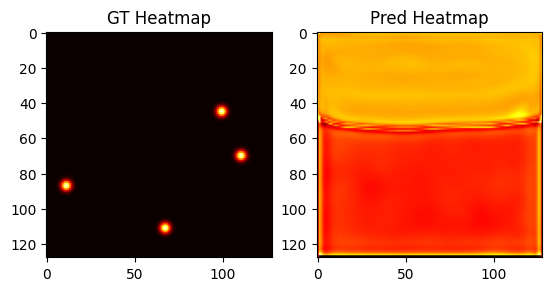

Train loss : 44.0721
Train mask loss : 110.0341
Train regr loss : 0.0975


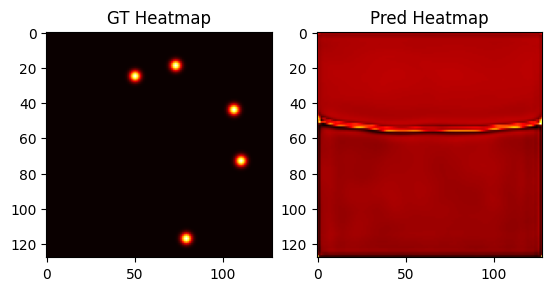

Validation loss : 38.8860
Validation mask loss : 97.0565
Validation regr loss : 0.1056
epochs 7/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 44.0346
Train mask loss : 109.9398
Train regr loss : 0.0978
Validation loss : 38.3522
Validation mask loss : 95.7127
Validation regr loss : 0.1119
epochs 8/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 43.2273
Train mask loss : 107.9210
Train regr loss : 0.0982
Validation loss : 38.1019
Validation mask loss : 95.0904
Validation regr loss : 0.1096
epochs 9/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.2298
Train mask loss : 105.4249
Train regr loss : 0.0998
Validation loss : 37.9671
Validation mask loss : 94.5955
Validation regr loss : 0.2148
epochs 10/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.1535
Train mask loss : 105.2363
Train regr loss : 0.0983
Validation loss : 37.8836
Validation mask loss : 94.1808
Validation regr loss : 0.3521
epochs 11/80


  0%|          | 0/68 [00:00<?, ?it/s]

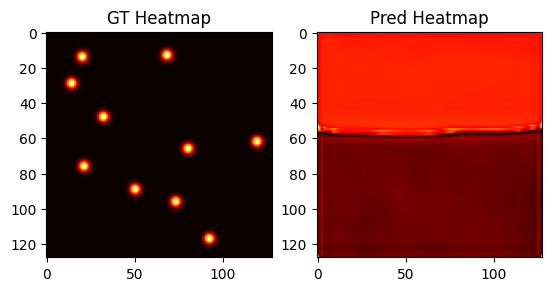

Train loss : 42.2115
Train mask loss : 105.3835
Train regr loss : 0.0968


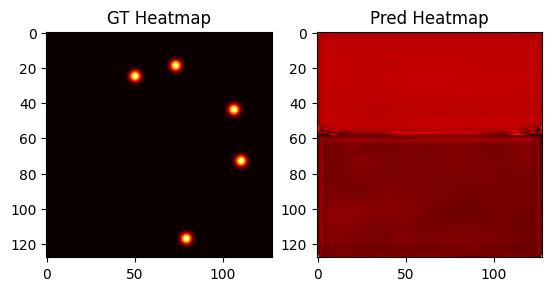

Validation loss : 37.6978
Validation mask loss : 94.0907
Validation regr loss : 0.1026
epochs 12/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.7273
Train mask loss : 104.1777
Train regr loss : 0.0937
Validation loss : 37.6878
Validation mask loss : 94.0431
Validation regr loss : 0.1175
epochs 13/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.2977
Train mask loss : 105.6065
Train regr loss : 0.0918
Validation loss : 37.6705
Validation mask loss : 94.0254
Validation regr loss : 0.1005
epochs 14/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.5012
Train mask loss : 106.1200
Train regr loss : 0.0886
Validation loss : 37.6634
Validation mask loss : 94.0128
Validation regr loss : 0.0971
epochs 15/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.9857
Train mask loss : 104.8347
Train regr loss : 0.0863
Validation loss : 37.6653
Validation mask loss : 94.0015
Validation regr loss : 0.1079
epochs 16/80


  0%|          | 0/68 [00:00<?, ?it/s]

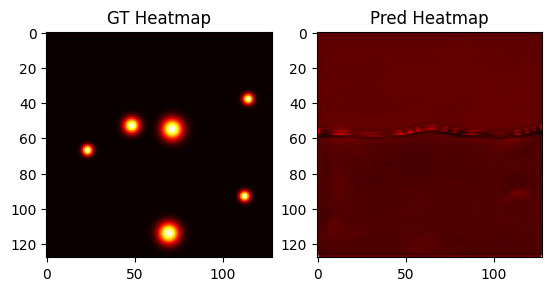

Train loss : 42.7005
Train mask loss : 106.6260
Train regr loss : 0.0835


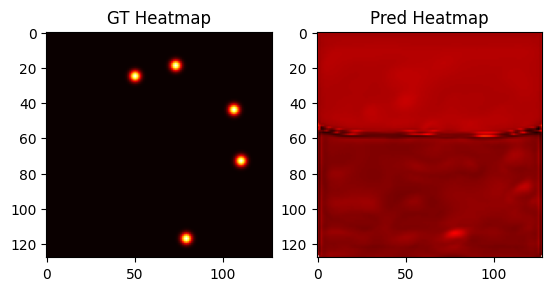

Validation loss : 37.6540
Validation mask loss : 93.9967
Validation regr loss : 0.0922
epochs 17/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.5546
Train mask loss : 106.2675
Train regr loss : 0.0794
Validation loss : 37.6497
Validation mask loss : 93.9938
Validation regr loss : 0.0871
epochs 18/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.8004
Train mask loss : 104.3884
Train regr loss : 0.0751
Validation loss : 37.6477
Validation mask loss : 93.9897
Validation regr loss : 0.0864
epochs 19/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.4275
Train mask loss : 105.9626
Train regr loss : 0.0708
Validation loss : 37.6441
Validation mask loss : 93.9865
Validation regr loss : 0.0826
epochs 20/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.8719
Train mask loss : 104.5793
Train regr loss : 0.0669
Validation loss : 37.6407
Validation mask loss : 93.9848
Validation regr loss : 0.0779
epochs 21/80


  0%|          | 0/68 [00:00<?, ?it/s]

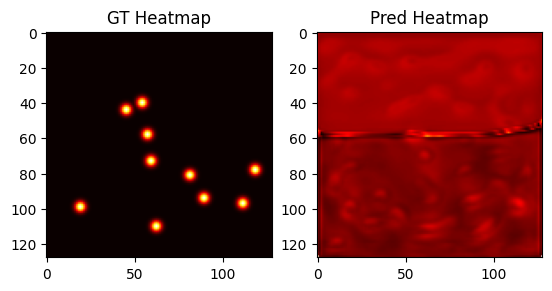

Train loss : 42.2900
Train mask loss : 105.6332
Train regr loss : 0.0612


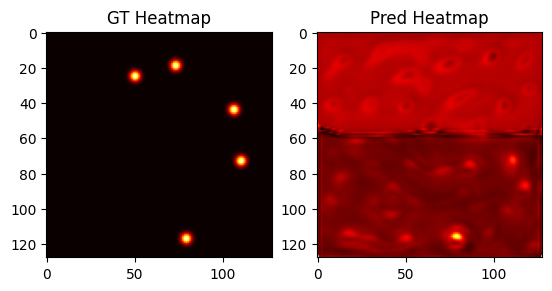

Validation loss : 37.6373
Validation mask loss : 93.9825
Validation regr loss : 0.0739
epochs 22/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.8981
Train mask loss : 104.6593
Train regr loss : 0.0573
Validation loss : 37.6412
Validation mask loss : 93.9809
Validation regr loss : 0.0813
epochs 23/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.9349
Train mask loss : 104.7567
Train regr loss : 0.0536
Validation loss : 37.6320
Validation mask loss : 93.9802
Validation regr loss : 0.0666
epochs 24/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.5254
Train mask loss : 106.2392
Train regr loss : 0.0494
Validation loss : 37.6319
Validation mask loss : 93.9788
Validation regr loss : 0.0673
epochs 25/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.8345
Train mask loss : 104.5153
Train regr loss : 0.0473
Validation loss : 37.6262
Validation mask loss : 93.9784
Validation regr loss : 0.0581
epochs 26/80


  0%|          | 0/68 [00:00<?, ?it/s]

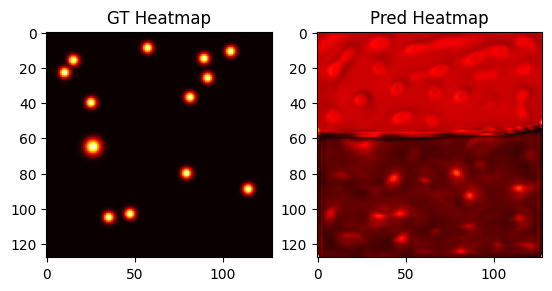

Train loss : 41.9537
Train mask loss : 104.8183
Train regr loss : 0.0440


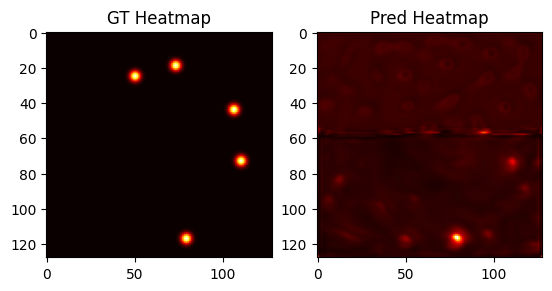

Validation loss : 37.6260
Validation mask loss : 93.9773
Validation regr loss : 0.0585
epochs 27/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.0920
Train mask loss : 105.1680
Train regr loss : 0.0413
Validation loss : 37.6242
Validation mask loss : 93.9767
Validation regr loss : 0.0558
epochs 28/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.5910
Train mask loss : 106.4174
Train regr loss : 0.0401
Validation loss : 37.6268
Validation mask loss : 93.9758
Validation regr loss : 0.0608
epochs 29/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.5513
Train mask loss : 103.8218
Train regr loss : 0.0376
Validation loss : 37.6217
Validation mask loss : 93.9757
Validation regr loss : 0.0524
epochs 30/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.5538
Train mask loss : 106.3288
Train regr loss : 0.0371
Validation loss : 37.6233
Validation mask loss : 93.9752
Validation regr loss : 0.0555
epochs 31/80


  0%|          | 0/68 [00:00<?, ?it/s]

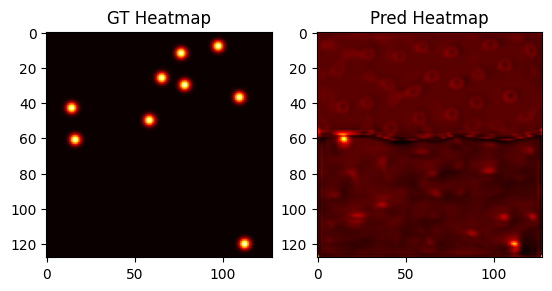

Train loss : 42.1125
Train mask loss : 105.2276
Train regr loss : 0.0357


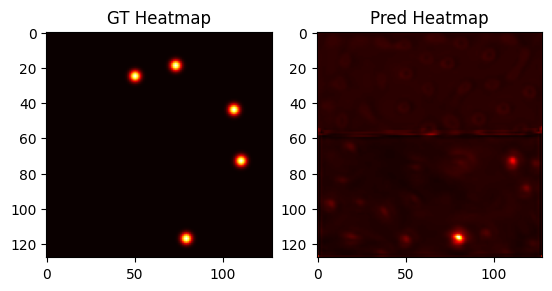

Validation loss : 37.6240
Validation mask loss : 93.9745
Validation regr loss : 0.0569
epochs 32/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.0127
Train mask loss : 104.9804
Train regr loss : 0.0342
Validation loss : 37.6213
Validation mask loss : 93.9742
Validation regr loss : 0.0526
epochs 33/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.5132
Train mask loss : 106.2360
Train regr loss : 0.0314
Validation loss : 37.6177
Validation mask loss : 93.9738
Validation regr loss : 0.0469
epochs 34/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.4380
Train mask loss : 106.0473
Train regr loss : 0.0319
Validation loss : 37.6175
Validation mask loss : 93.9735
Validation regr loss : 0.0469
epochs 35/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.4662
Train mask loss : 106.1206
Train regr loss : 0.0299
Validation loss : 37.6160
Validation mask loss : 93.9732
Validation regr loss : 0.0445
epochs 36/80


  0%|          | 0/68 [00:00<?, ?it/s]

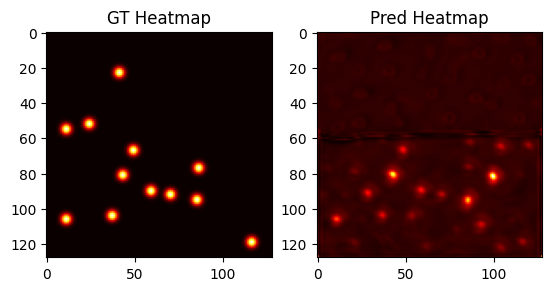

Train loss : 41.9132
Train mask loss : 104.7384
Train regr loss : 0.0298


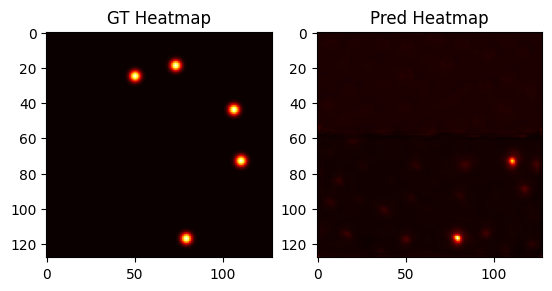

Validation loss : 37.6162
Validation mask loss : 93.9726
Validation regr loss : 0.0454
epochs 37/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.1927
Train mask loss : 105.4396
Train regr loss : 0.0281
Validation loss : 37.6156
Validation mask loss : 93.9726
Validation regr loss : 0.0443
epochs 38/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.8997
Train mask loss : 104.7132
Train regr loss : 0.0240
Validation loss : 37.6115
Validation mask loss : 93.9726
Validation regr loss : 0.0374
epochs 39/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.7753
Train mask loss : 106.9097
Train regr loss : 0.0190
Validation loss : 37.6105
Validation mask loss : 93.9724
Validation regr loss : 0.0359
epochs 40/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.2557
Train mask loss : 105.6124
Train regr loss : 0.0179
Validation loss : 37.6111
Validation mask loss : 93.9724
Validation regr loss : 0.0369
epochs 41/80


  0%|          | 0/68 [00:00<?, ?it/s]

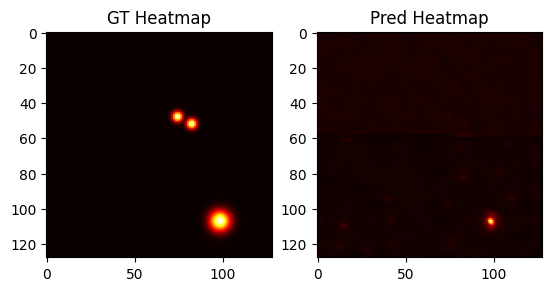

Train loss : 42.4480
Train mask loss : 106.0920
Train regr loss : 0.0187


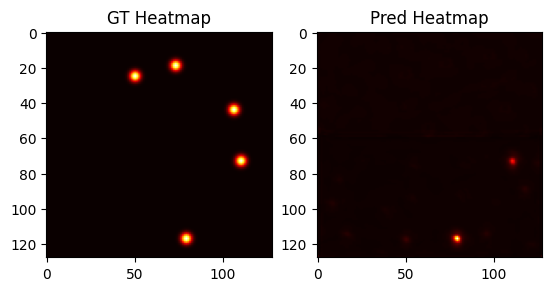

Validation loss : 37.6119
Validation mask loss : 93.9722
Validation regr loss : 0.0383
epochs 42/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.1643
Train mask loss : 105.3851
Train regr loss : 0.0172
Validation loss : 37.6093
Validation mask loss : 93.9721
Validation regr loss : 0.0341
epochs 43/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.1873
Train mask loss : 105.4473
Train regr loss : 0.0139
Validation loss : 37.6079
Validation mask loss : 93.9720
Validation regr loss : 0.0318
epochs 44/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.8391
Train mask loss : 104.5791
Train regr loss : 0.0125
Validation loss : 37.6075
Validation mask loss : 93.9720
Validation regr loss : 0.0311
epochs 45/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.6346
Train mask loss : 106.5682
Train regr loss : 0.0123
Validation loss : 37.6069
Validation mask loss : 93.9719
Validation regr loss : 0.0302
epochs 46/80


  0%|          | 0/68 [00:00<?, ?it/s]

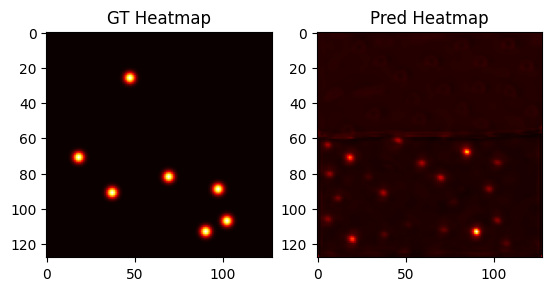

Train loss : 42.1308
Train mask loss : 105.3098
Train regr loss : 0.0115


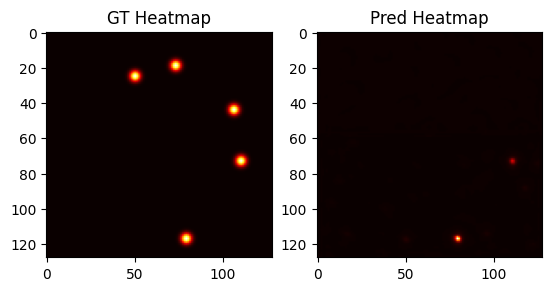

Validation loss : 37.6071
Validation mask loss : 93.9719
Validation regr loss : 0.0306
epochs 47/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.7979
Train mask loss : 104.4779
Train regr loss : 0.0113
Validation loss : 37.6075
Validation mask loss : 93.9718
Validation regr loss : 0.0313
epochs 48/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.1069
Train mask loss : 105.2506
Train regr loss : 0.0112
Validation loss : 37.6067
Validation mask loss : 93.9681
Validation regr loss : 0.0324
epochs 49/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.3956
Train mask loss : 105.9705
Train regr loss : 0.0124
Validation loss : 37.6026
Validation mask loss : 93.9598
Validation regr loss : 0.0311
epochs 50/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.3133
Train mask loss : 105.7643
Train regr loss : 0.0126
Validation loss : 37.6000
Validation mask loss : 93.9535
Validation regr loss : 0.0310
epochs 51/80


  0%|          | 0/68 [00:00<?, ?it/s]

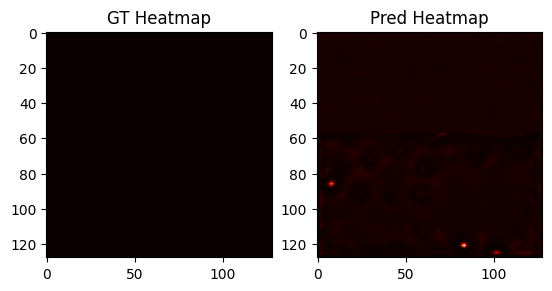

Train loss : 42.0330
Train mask loss : 105.0641
Train regr loss : 0.0122


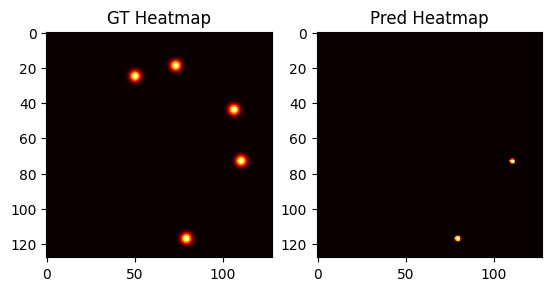

Validation loss : 37.5993
Validation mask loss : 93.9506
Validation regr loss : 0.0317
epochs 52/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.5437
Train mask loss : 106.3412
Train regr loss : 0.0120
Validation loss : 37.5984
Validation mask loss : 93.9489
Validation regr loss : 0.0314
epochs 53/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.8255
Train mask loss : 104.5461
Train regr loss : 0.0117
Validation loss : 37.5976
Validation mask loss : 93.9457
Validation regr loss : 0.0322
epochs 54/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.2322
Train mask loss : 105.5621
Train regr loss : 0.0123
Validation loss : 37.5963
Validation mask loss : 93.9442
Validation regr loss : 0.0311
epochs 55/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.7952
Train mask loss : 106.9681
Train regr loss : 0.0132
Validation loss : 37.5947
Validation mask loss : 93.9393
Validation regr loss : 0.0316
epochs 56/80


  0%|          | 0/68 [00:00<?, ?it/s]

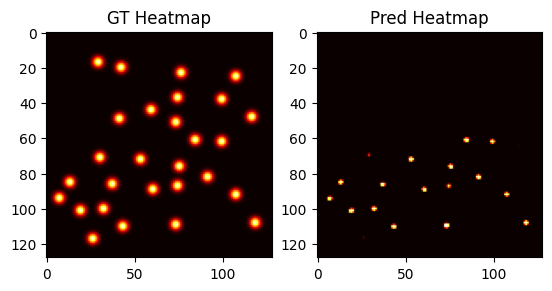

Train loss : 42.0199
Train mask loss : 105.0301
Train regr loss : 0.0132


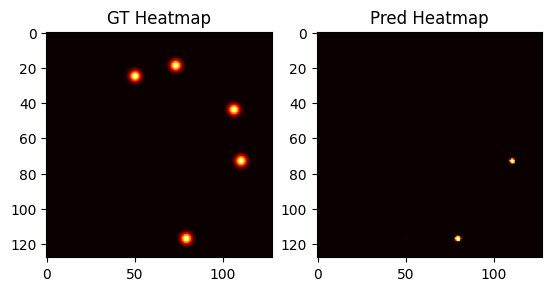

Validation loss : 37.5956
Validation mask loss : 93.9407
Validation regr loss : 0.0322
epochs 57/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.0264
Train mask loss : 105.0473
Train regr loss : 0.0124
Validation loss : 37.5942
Validation mask loss : 93.9375
Validation regr loss : 0.0320
epochs 58/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.4256
Train mask loss : 106.0455
Train regr loss : 0.0124
Validation loss : 37.5928
Validation mask loss : 93.9349
Validation regr loss : 0.0314
epochs 59/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.2061
Train mask loss : 105.4973
Train regr loss : 0.0119
Validation loss : 37.5934
Validation mask loss : 93.9367
Validation regr loss : 0.0313
epochs 60/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.5101
Train mask loss : 106.2573
Train regr loss : 0.0119
Validation loss : 37.5942
Validation mask loss : 93.9391
Validation regr loss : 0.0309
epochs 61/80


  0%|          | 0/68 [00:00<?, ?it/s]

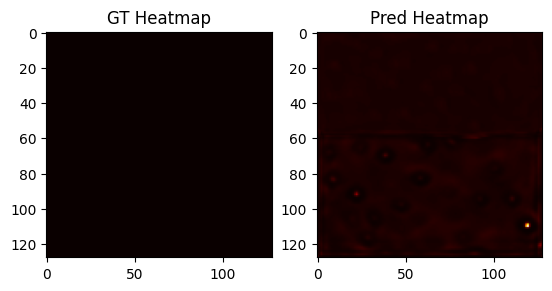

Train loss : 41.9543
Train mask loss : 104.8683
Train regr loss : 0.0116


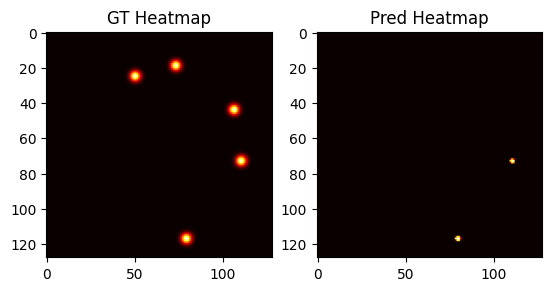

Validation loss : 37.5925
Validation mask loss : 93.9351
Validation regr loss : 0.0307
epochs 62/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.1308
Train mask loss : 105.3102
Train regr loss : 0.0111
Validation loss : 37.5927
Validation mask loss : 93.9349
Validation regr loss : 0.0312
epochs 63/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.1698
Train mask loss : 105.4079
Train regr loss : 0.0110
Validation loss : 37.5918
Validation mask loss : 93.9331
Validation regr loss : 0.0309
epochs 64/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.9323
Train mask loss : 104.8146
Train regr loss : 0.0107
Validation loss : 37.5923
Validation mask loss : 93.9347
Validation regr loss : 0.0306
epochs 65/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.2019
Train mask loss : 105.4885
Train regr loss : 0.0109
Validation loss : 37.5935
Validation mask loss : 93.9375
Validation regr loss : 0.0308
epochs 66/80


  0%|          | 0/68 [00:00<?, ?it/s]

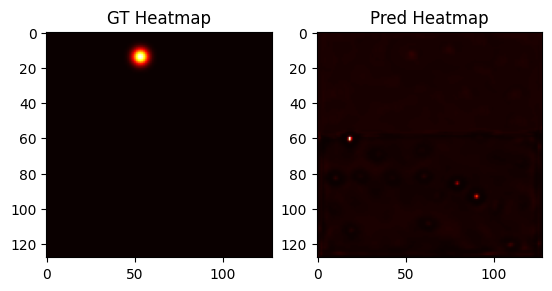

Train loss : 41.8754
Train mask loss : 104.6723
Train regr loss : 0.0107


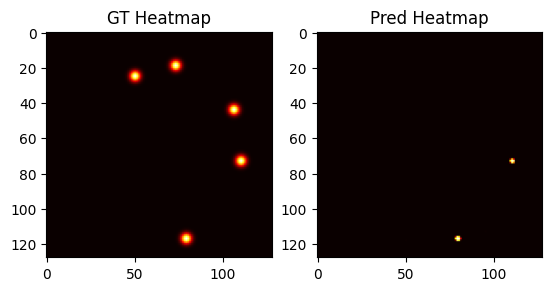

Validation loss : 37.5923
Validation mask loss : 93.9352
Validation regr loss : 0.0304
epochs 67/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.1509
Train mask loss : 105.3609
Train regr loss : 0.0109
Validation loss : 37.5919
Validation mask loss : 93.9338
Validation regr loss : 0.0306
epochs 68/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.1685
Train mask loss : 105.4053
Train regr loss : 0.0107
Validation loss : 37.5921
Validation mask loss : 93.9346
Validation regr loss : 0.0304
epochs 69/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.2095
Train mask loss : 105.5082
Train regr loss : 0.0104
Validation loss : 37.5929
Validation mask loss : 93.9368
Validation regr loss : 0.0303
epochs 70/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.7630
Train mask loss : 104.3922
Train regr loss : 0.0102
Validation loss : 37.5922
Validation mask loss : 93.9350
Validation regr loss : 0.0303
epochs 71/80


  0%|          | 0/68 [00:00<?, ?it/s]

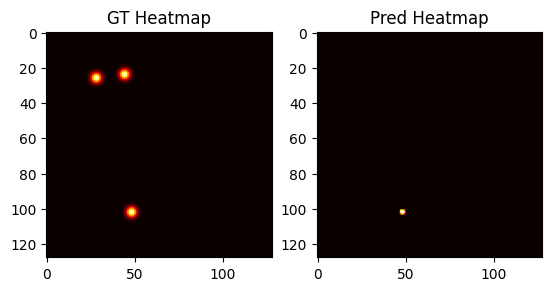

Train loss : 41.8328
Train mask loss : 104.5665
Train regr loss : 0.0103


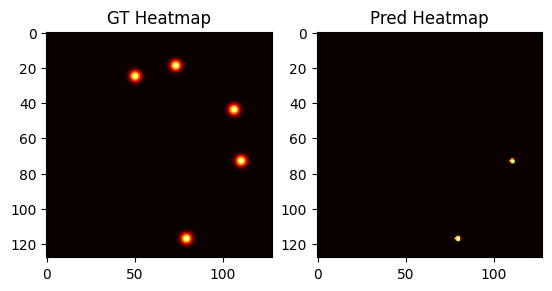

Validation loss : 37.5927
Validation mask loss : 93.9362
Validation regr loss : 0.0304
epochs 72/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.4204
Train mask loss : 106.0354
Train regr loss : 0.0104
Validation loss : 37.5918
Validation mask loss : 93.9328
Validation regr loss : 0.0312
epochs 73/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 41.9636
Train mask loss : 104.8934
Train regr loss : 0.0103
Validation loss : 37.5917
Validation mask loss : 93.9342
Validation regr loss : 0.0300
epochs 74/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.5188
Train mask loss : 106.2815
Train regr loss : 0.0103
Validation loss : 37.5917
Validation mask loss : 93.9341
Validation regr loss : 0.0300
epochs 75/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.4649
Train mask loss : 106.1466
Train regr loss : 0.0104
Validation loss : 37.5918
Validation mask loss : 93.9343
Validation regr loss : 0.0302
epochs 76/80


  0%|          | 0/68 [00:00<?, ?it/s]

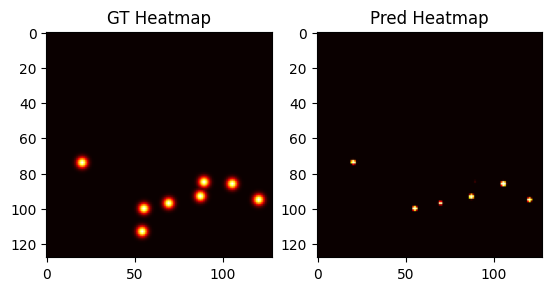

Train loss : 42.3117
Train mask loss : 105.7640
Train regr loss : 0.0102


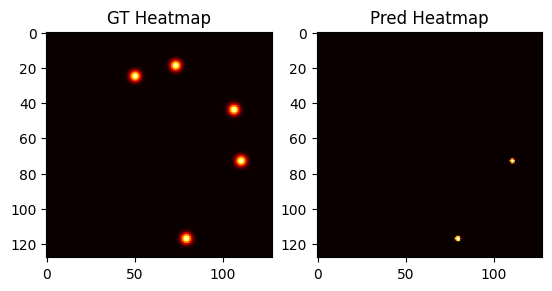

Validation loss : 37.5916
Validation mask loss : 93.9340
Validation regr loss : 0.0300
epochs 77/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.8085
Train mask loss : 107.0055
Train regr loss : 0.0106
Validation loss : 37.5920
Validation mask loss : 93.9350
Validation regr loss : 0.0300
epochs 78/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.2280
Train mask loss : 105.5546
Train regr loss : 0.0102
Validation loss : 37.5923
Validation mask loss : 93.9356
Validation regr loss : 0.0301
epochs 79/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.0932
Train mask loss : 105.2179
Train regr loss : 0.0101
Validation loss : 37.5916
Validation mask loss : 93.9339
Validation regr loss : 0.0301
epochs 80/80


  0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 42.0135
Train mask loss : 105.0188
Train regr loss : 0.0101
Validation loss : 37.5920
Validation mask loss : 93.9346
Validation regr loss : 0.0303


In [29]:
epochs=80
logs = []
logs_eval = []

if TRAIN:
    for epoch in range(epochs):
        train(epoch)
else:
    model.load_state_dict(torch.load(MODEL_PATH))